# Deliverable for Improvement 2


**Group 16**

Sarim Malik (26100129), Muhammad Nafees (26100029)

**Note:** non-IID partitioning framework and evaluation metrics shall be kept constant across all the baseline model development.


# Knowledge Carrier: Logit Based

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np
from torch.utils.data import Dataset, DataLoader, Subset, random_split
import matplotlib.pyplot as plt
from collections import Counter
import copy
import random
from typing import Dict, List, Tuple
import math

import pandas as pd
# random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [2]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 10)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 128 * 4 * 4)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

    def get_features(self, x):

        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 128 * 4 * 4)
        x = self.dropout(F.relu(self.fc1(x)))
        return x

In [3]:
def load_and_partition_data():
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    #  seeds for data partitioning
    torch.manual_seed(42)
    np.random.seed(42)
    random.seed(42)

    full_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
    test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

    n_total = len(full_dataset)
    n_server_val = int(0.1 * n_total)  # 10% for server validation
    n_client_data = n_total - n_server_val  # 90% for clients

    g = torch.Generator().manual_seed(42)
    client_data, server_val_data = random_split(full_dataset, [n_client_data, n_server_val], generator=g)

    client_indices = client_data.indices
    all_targets = np.array(full_dataset.targets)
    labels = all_targets[client_indices]

    num_classes = 10
    num_clients = NUM_OF_CLIENTS

    np.random.seed(42)
    client_label_distribution = np.random.dirichlet(np.repeat(ALPHA, num_clients), size=num_classes)

    class_indices = [np.where(labels == class_idx)[0] for class_idx in range(num_classes)]

    client_indices = [[] for _ in range(num_clients)]

    for class_idx, distribution in enumerate(client_label_distribution):
        class_size = len(class_indices[class_idx])
        num_samples_per_client = (distribution * class_size).astype(int)
        samples_assigned = 0

        for client_idx, num_samples in enumerate(num_samples_per_client):
            if client_idx == num_clients - 1:
                num_samples = class_size - samples_assigned

            if num_samples > 0:
                selected_indices = class_indices[class_idx][samples_assigned:samples_assigned+num_samples]
                client_indices[client_idx].extend(selected_indices)
                samples_assigned += num_samples

    client_datasets = []
    client_train_loaders = []
    client_val_loaders = []
    client_class_distributions = []

    for client_idx, indices in enumerate(client_indices):
        np.random.seed(42 + client_idx)
        np.random.shuffle(indices)

        client_labels = [labels[i] for i in indices]
        class_counts = Counter(client_labels)
        distribution = {cls: count/len(client_labels) for cls, count in class_counts.items()}
        client_class_distributions.append(distribution)

        n_train = int(0.8 * len(indices))
        train_indices = indices[:n_train]
        val_indices = indices[n_train:]

        train_indices_original = [client_data.indices[i] for i in train_indices]
        val_indices_original = [client_data.indices[i] for i in val_indices]

        client_train_dataset = Subset(full_dataset, train_indices_original)
        client_val_dataset = Subset(full_dataset, val_indices_original)

        g_train = torch.Generator().manual_seed(42 + client_idx)
        g_val = torch.Generator().manual_seed(42 + client_idx + num_clients)

        train_loader = DataLoader(client_train_dataset, batch_size=BATCH_SIZE,
                                  shuffle=True, generator=g_train)
        val_loader = DataLoader(client_val_dataset, batch_size=BATCH_SIZE,
                                generator=g_val)

        client_datasets.append((client_train_dataset, client_val_dataset))
        client_train_loaders.append(train_loader)
        client_val_loaders.append(val_loader)

    g_server = torch.Generator().manual_seed(42 + 2*num_clients)
    g_test = torch.Generator().manual_seed(42 + 2*num_clients + 1)

    server_val_loader = DataLoader(server_val_data, batch_size=BATCH_SIZE, generator=g_server)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, generator=g_test)

    print("Data partitioning complete.")
    for i, dist in enumerate(client_class_distributions):
        print(f"Client {i} class distribution:")
        for cls in range(10):
            print(f"  Class {cls}: {dist.get(cls, 0):.2f}")

    # reset random seeds
    torch.manual_seed(42)
    np.random.seed(42)
    random.seed(42)

    return client_train_loaders, client_val_loaders, server_val_loader, test_loader, client_class_distributions

---

## Utility Functions

In [ ]:
def temperature_cross_entropy_loss(logits, targets, temperature):
    """Compute cross-entropy loss using softmax with temperature scaling."""
    probs = torch.softmax(logits / temperature, dim=1)
    log_probs = torch.log(probs + 1e-8)
    one_hot = F.one_hot(targets, num_classes=logits.size(1)).float()
    loss = -(one_hot * log_probs).sum(dim=1).mean()
    return loss

def calculate_global_distribution(client_distributions):
    """
    Calculate approximate global class distribution from client distributions
    """
    global_dist = {}
    n_clients = len(client_distributions)


    for cls in range(10):
        global_dist[cls] = sum(dist.get(cls, 0) for dist in client_distributions) / n_clients


    for cls in range(10):
        if global_dist[cls] < 0.01:
            global_dist[cls] = 0.01


    total = sum(global_dist.values())
    global_dist = {k: v/total for k, v in global_dist.items()}

    return global_dist

def calculate_heterogeneity_score(client_distribution, global_distribution):
    """
    Calculate how different client's class distribution is from global distribution
    """
    score = 0
    for cls in range(10):
        client_prob = client_distribution.get(cls, 0)
        global_prob = global_distribution.get(cls, 1/10)
        if client_prob > 0 and global_prob > 0:

            ratio = client_prob / global_prob
            score += abs(ratio - 1)

    # normalize to [0, 1] range approximately
    score = min(score / 10, 1)
    return score


def client_local_train(model, train_loader, optimizer, temperature, epochs=1):
    """Local training on client using modified softmax loss."""
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = temperature_cross_entropy_loss(outputs, targets, temperature)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Client local training - Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}")

def calculate_client_temperature(client_distribution, global_distribution):
    """
    Calculate a temperature in (0,1) based on heterogeneity.
    A high heterogeneity score (close to 1) yields a temperature close to 0.01.
    A low heterogeneity score (close to 0) yields a temperature close to 0.99.
    """
    score = calculate_heterogeneity_score(client_distribution, global_distribution)
    # map heterogeneity score linearly into (0.01, 0.99)
    client_temp = 0.99 - 0.98 * score

    client_temp = min(max(client_temp, 0.01), 0.99) #(0,1)
    return client_temp

def calculate_client_temperature_EXP(client_distribution, global_distribution):
    
    score = calculate_heterogeneity_score(client_distribution, global_distribution)

    client_temp = 0.99 * math.exp(-3 * score) #uisng k = 3  

    client_temp = min(max(client_temp, 0.01), 0.99) #(0,1)
    return client_temp, score

def client_predict_logits(model, public_loader):
    """Clients predict and upload local logits for the unlabeled public dataset."""
    model.eval()
    all_logits = []
    with torch.no_grad():
        for inputs, _ in public_loader:
            inputs = inputs.to(device)
            logits = model(inputs)
            all_logits.append(logits.cpu())
    return torch.cat(all_logits, dim=0)


#Model Improvement 2
def standardize_logits(logits: torch.Tensor, eps: float = 1e-6) -> torch.Tensor:

    mean = logits.mean(dim=-1, keepdim=True)
    std = logits.std(dim=-1, keepdim=True)
    return (logits - mean) / (std + eps)

def aggregate_logits(clients_logits):
    """Server side aggregation: simple average of client logits."""
    aggregated = torch.mean(torch.stack(clients_logits), dim=0)
    return aggregated

#Model Improvement 2
def aggregate_logits_standardized(clients_logits: list[torch.Tensor], eps: float = 1e-6) -> torch.Tensor:

    standardized = [standardize_logits(logit, eps) for logit in clients_logits]
    aggregated = torch.mean(torch.stack(standardized), dim=0)
    return aggregated


def server_distillation_update(global_model, public_loader, aggregated_logits, optimizer, temperature, epochs=1):

    global_model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for idx, (inputs, _) in enumerate(public_loader):
            inputs = inputs.to(device)
            batch_size = inputs.size(0)

            agg_logits_batch = aggregated_logits[idx*batch_size: idx*batch_size+batch_size].to(device)
            optimizer.zero_grad()
            outputs = global_model(inputs)
            loss = F.kl_div(F.log_softmax(outputs / temperature, dim=1),
                            F.softmax(agg_logits_batch / temperature, dim=1),
                            reduction='batchmean') * (temperature ** 2)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Server KD distillation - Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(public_loader):.4f}")

#Model Improvement 2
def server_distillation_update_standardized(global_model, public_loader, aggregated_logits, optimizer, temperature, epochs=1):
    global_model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for idx, (inputs, _) in enumerate(public_loader):
            inputs = inputs.to(device)
            batch_size = inputs.size(0)
            agg_logits_batch = aggregated_logits[idx*batch_size: idx*batch_size+batch_size].to(device)

            outputs = global_model(inputs)
            #Only standardize the student’s logits since agg.logits were already standardized
            outputs_std = standardize_logits(outputs)

            loss = F.kl_div(
                F.log_softmax(outputs_std / temperature, dim=1),
                F.softmax(agg_logits_batch / temperature, dim=1),
                reduction='batchmean'
            ) * (temperature ** 2)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        print(f"Server KD distillation - Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(public_loader):.4f}")

def client_distillation_update(model, public_loader, aggregated_logits, optimizer, temperature, epochs=1):

    model.train()
    epoch_accs = []
    for epoch in range(epochs):
        running_loss = 0.0
        for idx, (inputs, _) in enumerate(public_loader):
            inputs = inputs.to(device)
            batch_size = inputs.size(0)
            agg_logits_batch = aggregated_logits[idx*batch_size: idx*batch_size+batch_size].to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = F.kl_div(F.log_softmax(outputs / temperature, dim=1),
                            F.softmax(agg_logits_batch / temperature, dim=1),
                            reduction='batchmean') * (temperature ** 2)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # evaluate on public data after the epoch
        model.eval()
        acc = evaluate_model(model, public_loader)
        epoch_accs.append(acc)
        print(f"Client distillation update - Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(public_loader):.4f}, Accuracy: {acc:.2f}%")
        model.train()
    return epoch_accs

def client_distillation_update_standardized(model, public_loader, aggregated_logits, optimizer, temperature, epochs=1):
    model.train()
    epoch_accs = []
    for epoch in range(epochs):
        running_loss = 0.0
        for idx, (inputs, _) in enumerate(public_loader):
            inputs = inputs.to(device)
            batch_size = inputs.size(0)
            agg_logits_batch = aggregated_logits[idx*batch_size: idx*batch_size+batch_size].to(device)

            outputs = model(inputs)
            #Only standardize the student’s logits since agg.logits were already standardized
            outputs_std = standardize_logits(outputs)

            loss = F.kl_div(
                F.log_softmax(outputs_std / temperature, dim=1),
                F.softmax(agg_logits_batch / temperature, dim=1),
                reduction='batchmean'
            ) * (temperature ** 2)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        model.eval()
        acc = evaluate_model(model, public_loader)
        epoch_accs.append(acc)
        print(f"Client distillation update - Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(public_loader):.4f}, Accuracy: {acc:.2f}%")
        model.train()
    return epoch_accs

def evaluate_model(model, data_loader):

    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
    return 100 * correct / total

def plot_accuracies(rounds, server_accuracies, client_accuracies):

    plt.figure(figsize=(8, 6))
    plt.plot(rounds, server_accuracies, label='Server Accuracy', marker='o')
    for i, acc in enumerate(client_accuracies):
        plt.plot(rounds, acc, label=f'Client {i} Accuracy', marker='o')
    plt.xlabel('Communication Rounds')
    plt.ylabel('Accuracy (%)')
    plt.title('Client and Server Accuracies over Rounds')
    plt.legend()
    plt.grid(True)
    plt.show()

# Baseline Model

This is the baseline model used as a reference point for further development and evaluation.


In [ ]:
def run_baseline_model():

    client_train_loaders, client_val_loaders, server_val_loader, test_loader, client_class_distributions = load_and_partition_data()
    num_clients = len(client_train_loaders)

    global_model = SimpleCNN().to(device)
    client_models = [copy.deepcopy(global_model).to(device) for _ in range(num_clients)]

    global_optimizer = optim.SGD(global_model.parameters(), lr=LEARNING_RATE)
    client_optimizers = [optim.SGD(model.parameters(), lr=LEARNING_RATE) for model in client_models]

    round_server_acc_list = []
    round_client_acc_list = [ [] for _ in range(num_clients) ]

    for br in range(COMM_ROUND):
        print("\n" + "=" * 20 + f" COMM ROUND {br + 1} " + "=" * 20)

        print("\n--- LOCAL TRAINING OF CLIENTS ---")
        for i in range(num_clients):
            print(f"\n--- Client {i} Local Training ---")
            client_local_train(client_models[i], client_train_loaders[i], client_optimizers[i], CLIENT_TEMPERATURE, epochs=NUM_EPOCHS)
            local_acc = evaluate_model(client_models[i], client_val_loaders[i])
            print(f"Client {i} Private Data Validation Accuracy: {local_acc:.2f}%")


        clients_logits = []
        for i in range(num_clients):
            print(f"\n--- Client {i} Generating Logits on Public Data ---")
            clients_logits.append(client_predict_logits(client_models[i], server_val_loader))

        # compute aggregated logits using client logits
        aggregated_logits = aggregate_logits(clients_logits)

        # server distillation update (global model update)
        print("\n--- Server KD Distillation Update ---")
        server_distillation_update(global_model, server_val_loader, aggregated_logits, global_optimizer, DISTILLATION_TEMPERATURE, epochs=SERVER_EPOCHS)
        pub_server_acc = evaluate_model(global_model, server_val_loader)
        print(f"Server Public Data Validation Accuracy: {pub_server_acc:.2f}%")
        round_server_acc_list.append(pub_server_acc)

        client_pub_pre_distillation = []
        for i in range(num_clients):         # evaluate & record clients' public data validation accuracy before client distillation update

            pre_acc = evaluate_model(client_models[i], server_val_loader)
            client_pub_pre_distillation.append(pre_acc)
            print(f"Client {i} Public Data Validation Accuracy before distillation: {pre_acc:.2f}%")


        client_epoch_progress_round = [] ## each client performs a distillation update with epoch-wise progress reporting
        for i in range(num_clients):
            print(f"\n--- Client {i} Distillation Update ---")
            epoch_accs = client_distillation_update(client_models[i], server_val_loader, aggregated_logits, client_optimizers[i], DISTILLATION_TEMPERATURE, epochs=DISTILLATION_CLIENT_EPOCHS)
            client_epoch_progress_round.append(epoch_accs)
            round_client_acc_list[i].append(epoch_accs[-1])

        # for showing client improvement (epoch-wise) for the round
        plt.figure(figsize=(8, 6))
        for i, epoch_accs in enumerate(client_epoch_progress_round):
            epochs_range = list(range(1, len(epoch_accs) + 1))
            line, = plt.plot(epochs_range, epoch_accs, marker='o', label=f'Client {i}')
            color = line.get_color()
            # mark pre-distillation accuracy at epoch 0
            plt.scatter(0, client_pub_pre_distillation[i], marker='X', s=100, color=color,
                        label=f'Client {i} Pre-Distillation' if br == 0 else "")
        plt.xlabel('Distillation Epoch')
        plt.ylabel('Accuracy (%)')
        plt.title(f'Client Improvement During Distillation (Comm Round {br + 1})')
        plt.legend()
        plt.grid(True)
        plt.show()


    rounds = list(range(1, COMM_ROUND + 1)) # plot overall server accuracy over rounds
    plt.figure(figsize=(8, 6))
    plt.plot(rounds, round_server_acc_list, marker='o', label='Server Accuracy')
    plt.xlabel('Comm Rounds')
    plt.ylabel('Accuracy (%)')
    plt.title('Server Accuracy over Comm Rounds')
    plt.legend()
    plt.grid(True)
    plt.show()

    # plot overall final post-round client accuracies over comm rounds
    plt.figure(figsize=(8, 6))
    for i in range(num_clients):
        plt.plot(rounds, round_client_acc_list[i], marker='o', label=f'Client {i} Accuracy')
    plt.xlabel('Comm Rounds')
    plt.ylabel('Accuracy (%)')
    plt.title('Client Final Post-Round Accuracy over Comm Rounds')
    plt.legend()
    plt.grid(True)
    plt.show()

    print("\n--- Clients Final Evaluation on Private Data sets ---")
    for i in range(num_clients):
        print(f"\n--- Client {i} Evaluation ---")
        local_acc = evaluate_model(client_models[i], client_val_loaders[i])
        print(f"Client {i} Final Private Data Validation Accuracy: {local_acc:.2f}%")


    final_test_acc = evaluate_model(global_model, test_loader)
    print(f"\nFinal Server Test Accuracy (on Public test_set): {final_test_acc:.2f}%")

# Running the baseline.

100%|██████████| 170M/170M [00:02<00:00, 73.9MB/s] 


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Data partitioning complete.
Client 0 class distribution:
  Class 0: 0.03
  Class 1: 0.03
  Class 2: 0.06
  Class 3: 0.29
  Class 4: 0.07
  Class 5: 0.20
  Class 6: 0.08
  Class 7: 0.17
  Class 8: 0.00
  Class 9: 0.07
Client 1 class distribution:
  Class 0: 0.23
  Class 1: 0.03
  Class 2: 0.09
  Class 3: 0.04
  Class 4: 0.16
  Class 5: 0.03
  Class 6: 0.22
  Class 7: 0.01
  Class 8: 0.16
  Class 9: 0.02
Client 2 class distribution:
  Class 0: 0.10
  Class 1: 0.01
  Class 2: 0.00
  Class 3: 0.04
  Class 4: 0.12
  Class 5: 0.08
  Class 6: 0.03
  Class 7: 0.20
  Class 8: 0.18
  Class 9: 0.23
Client 3 class distribution:
  Class 0: 0.06
  Class 1: 0.29
  Class 2: 0.21
  Class 3: 0.03
  Class 4: 0.06
  Class 5: 0.08
  Class 6: 0.08
  Class 7: 0.03
  Class 8: 0.07
  Class 9: 0.09

==================== COMM ROUND 1 ====================

--- LOCAL TRAINING OF CLIENTS ---

--- Client 0 Local Training ---
Cli

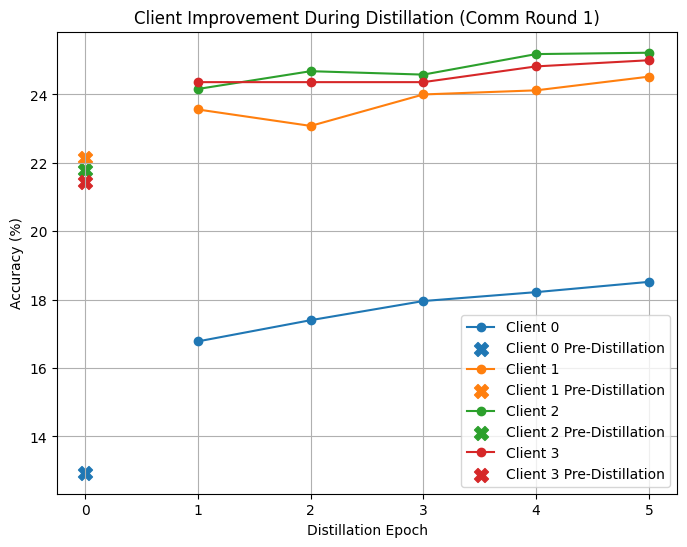


==================== COMM ROUND 2 ====================

--- LOCAL TRAINING OF CLIENTS ---

--- Client 0 Local Training ---
Client local training - Epoch [1/5], Loss: 1.8349
Client local training - Epoch [2/5], Loss: 1.8033
Client local training - Epoch [3/5], Loss: 1.7805
Client local training - Epoch [4/5], Loss: 1.7528
Client local training - Epoch [5/5], Loss: 1.7153
Client 0 Private Data Validation Accuracy: 36.46%

--- Client 1 Local Training ---
Client local training - Epoch [1/5], Loss: 1.6042
Client local training - Epoch [2/5], Loss: 1.5472
Client local training - Epoch [3/5], Loss: 1.5220
Client local training - Epoch [4/5], Loss: 1.4937
Client local training - Epoch [5/5], Loss: 1.4705
Client 1 Private Data Validation Accuracy: 42.36%

--- Client 2 Local Training ---
Client local training - Epoch [1/5], Loss: 1.6086
Client local training - Epoch [2/5], Loss: 1.5239
Client local training - Epoch [3/5], Loss: 1.4822
Client local training - Epoch [4/5], Loss: 1.4508
Client loc

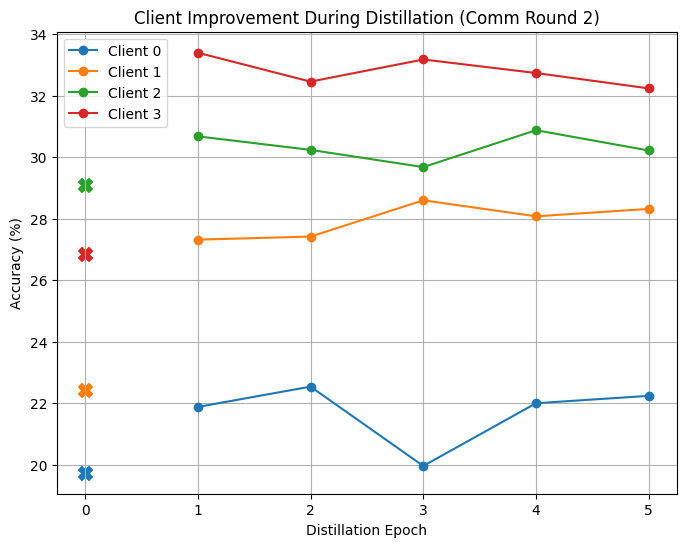


==================== COMM ROUND 3 ====================

--- LOCAL TRAINING OF CLIENTS ---

--- Client 0 Local Training ---
Client local training - Epoch [1/5], Loss: 1.6644
Client local training - Epoch [2/5], Loss: 1.6025
Client local training - Epoch [3/5], Loss: 1.5665
Client local training - Epoch [4/5], Loss: 1.5312
Client local training - Epoch [5/5], Loss: 1.4939
Client 0 Private Data Validation Accuracy: 41.94%

--- Client 1 Local Training ---
Client local training - Epoch [1/5], Loss: 1.4548
Client local training - Epoch [2/5], Loss: 1.4148
Client local training - Epoch [3/5], Loss: 1.3913
Client local training - Epoch [4/5], Loss: 1.3652
Client local training - Epoch [5/5], Loss: 1.3472
Client 1 Private Data Validation Accuracy: 50.44%

--- Client 2 Local Training ---
Client local training - Epoch [1/5], Loss: 1.4040
Client local training - Epoch [2/5], Loss: 1.3518
Client local training - Epoch [3/5], Loss: 1.3279
Client local training - Epoch [4/5], Loss: 1.2995
Client loc

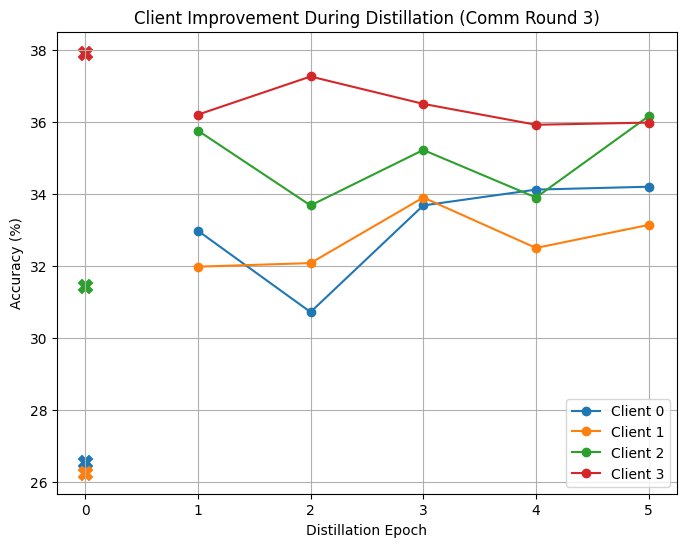


==================== COMM ROUND 4 ====================

--- LOCAL TRAINING OF CLIENTS ---

--- Client 0 Local Training ---
Client local training - Epoch [1/5], Loss: 1.4753
Client local training - Epoch [2/5], Loss: 1.4354
Client local training - Epoch [3/5], Loss: 1.4116
Client local training - Epoch [4/5], Loss: 1.3915
Client local training - Epoch [5/5], Loss: 1.3696
Client 0 Private Data Validation Accuracy: 41.59%

--- Client 1 Local Training ---
Client local training - Epoch [1/5], Loss: 1.3358
Client local training - Epoch [2/5], Loss: 1.3064
Client local training - Epoch [3/5], Loss: 1.2789
Client local training - Epoch [4/5], Loss: 1.2663
Client local training - Epoch [5/5], Loss: 1.2449
Client 1 Private Data Validation Accuracy: 50.44%

--- Client 2 Local Training ---
Client local training - Epoch [1/5], Loss: 1.2678
Client local training - Epoch [2/5], Loss: 1.2307
Client local training - Epoch [3/5], Loss: 1.2081
Client local training - Epoch [4/5], Loss: 1.1897
Client loc

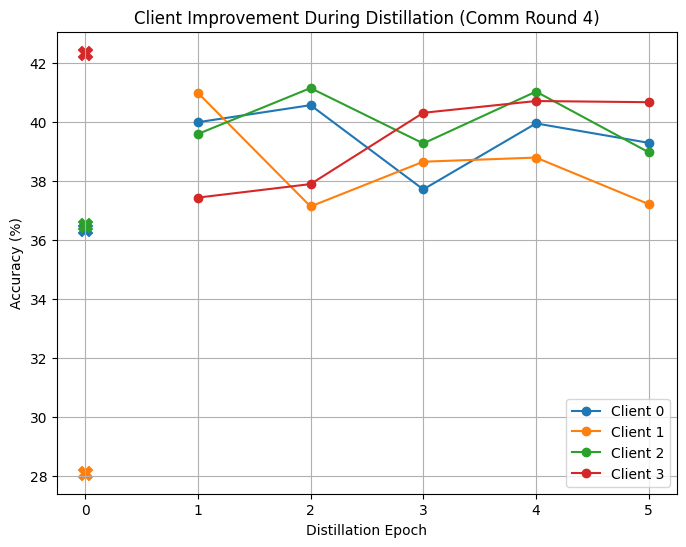


==================== COMM ROUND 5 ====================

--- LOCAL TRAINING OF CLIENTS ---

--- Client 0 Local Training ---
Client local training - Epoch [1/5], Loss: 1.3586
Client local training - Epoch [2/5], Loss: 1.3331
Client local training - Epoch [3/5], Loss: 1.3100
Client local training - Epoch [4/5], Loss: 1.3047
Client local training - Epoch [5/5], Loss: 1.2813
Client 0 Private Data Validation Accuracy: 48.16%

--- Client 1 Local Training ---
Client local training - Epoch [1/5], Loss: 1.2462
Client local training - Epoch [2/5], Loss: 1.2121
Client local training - Epoch [3/5], Loss: 1.1915
Client local training - Epoch [4/5], Loss: 1.1833
Client local training - Epoch [5/5], Loss: 1.1745
Client 1 Private Data Validation Accuracy: 56.82%

--- Client 2 Local Training ---
Client local training - Epoch [1/5], Loss: 1.1657
Client local training - Epoch [2/5], Loss: 1.1300
Client local training - Epoch [3/5], Loss: 1.1197
Client local training - Epoch [4/5], Loss: 1.0946
Client loc

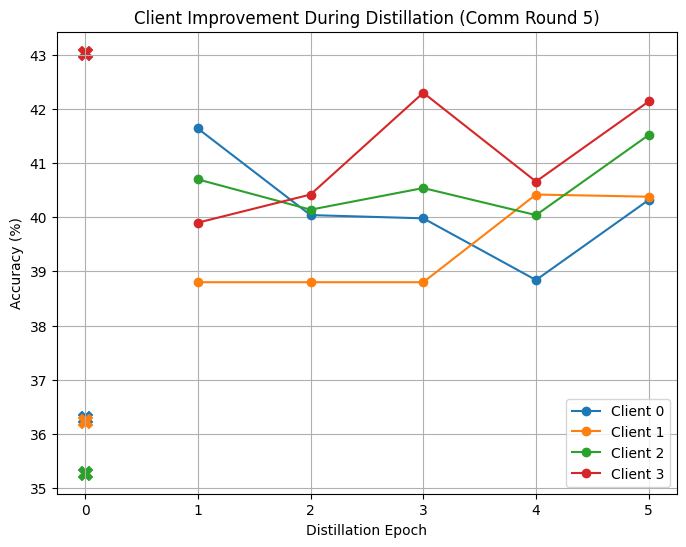


==================== COMM ROUND 6 ====================

--- LOCAL TRAINING OF CLIENTS ---

--- Client 0 Local Training ---
Client local training - Epoch [1/5], Loss: 1.2778
Client local training - Epoch [2/5], Loss: 1.2520
Client local training - Epoch [3/5], Loss: 1.2331
Client local training - Epoch [4/5], Loss: 1.2226
Client local training - Epoch [5/5], Loss: 1.2058
Client 0 Private Data Validation Accuracy: 50.96%

--- Client 1 Local Training ---
Client local training - Epoch [1/5], Loss: 1.1646
Client local training - Epoch [2/5], Loss: 1.1361
Client local training - Epoch [3/5], Loss: 1.1334
Client local training - Epoch [4/5], Loss: 1.1076
Client local training - Epoch [5/5], Loss: 1.0930
Client 1 Private Data Validation Accuracy: 58.66%

--- Client 2 Local Training ---
Client local training - Epoch [1/5], Loss: 1.0770
Client local training - Epoch [2/5], Loss: 1.0517
Client local training - Epoch [3/5], Loss: 1.0391
Client local training - Epoch [4/5], Loss: 1.0308
Client loc

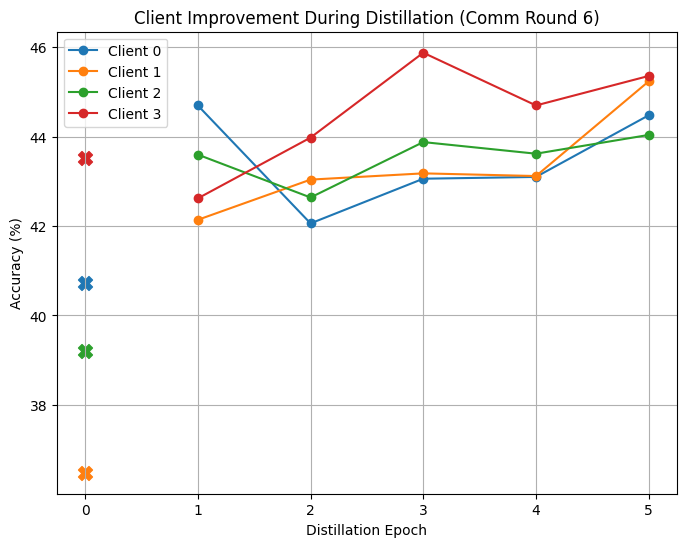


==================== COMM ROUND 7 ====================

--- LOCAL TRAINING OF CLIENTS ---

--- Client 0 Local Training ---
Client local training - Epoch [1/5], Loss: 1.2085
Client local training - Epoch [2/5], Loss: 1.1783
Client local training - Epoch [3/5], Loss: 1.1639
Client local training - Epoch [4/5], Loss: 1.1486
Client local training - Epoch [5/5], Loss: 1.1335
Client 0 Private Data Validation Accuracy: 51.05%

--- Client 1 Local Training ---
Client local training - Epoch [1/5], Loss: 1.1002
Client local training - Epoch [2/5], Loss: 1.0642
Client local training - Epoch [3/5], Loss: 1.0569
Client local training - Epoch [4/5], Loss: 1.0426
Client local training - Epoch [5/5], Loss: 1.0299
Client 1 Private Data Validation Accuracy: 59.67%

--- Client 2 Local Training ---
Client local training - Epoch [1/5], Loss: 1.0100
Client local training - Epoch [2/5], Loss: 0.9835
Client local training - Epoch [3/5], Loss: 0.9704
Client local training - Epoch [4/5], Loss: 0.9481
Client loc

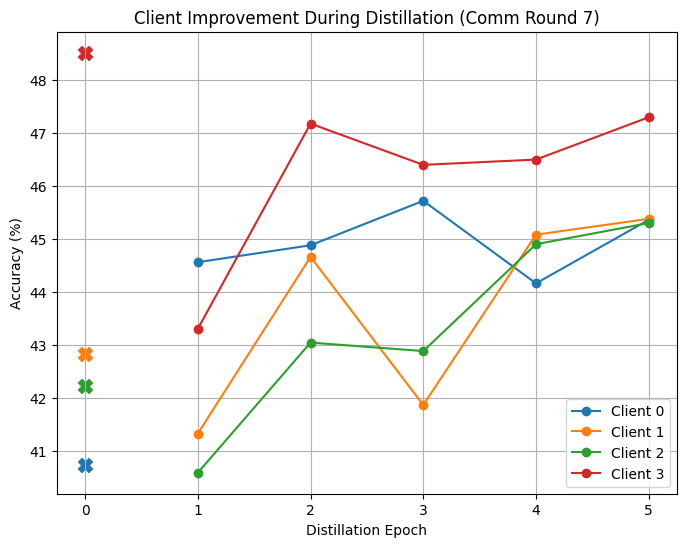


==================== COMM ROUND 8 ====================

--- LOCAL TRAINING OF CLIENTS ---

--- Client 0 Local Training ---
Client local training - Epoch [1/5], Loss: 1.1427
Client local training - Epoch [2/5], Loss: 1.1142
Client local training - Epoch [3/5], Loss: 1.0924
Client local training - Epoch [4/5], Loss: 1.0748
Client local training - Epoch [5/5], Loss: 1.0663
Client 0 Private Data Validation Accuracy: 53.99%

--- Client 1 Local Training ---
Client local training - Epoch [1/5], Loss: 1.0304
Client local training - Epoch [2/5], Loss: 1.0045
Client local training - Epoch [3/5], Loss: 0.9910
Client local training - Epoch [4/5], Loss: 0.9759
Client local training - Epoch [5/5], Loss: 0.9584
Client 1 Private Data Validation Accuracy: 60.20%

--- Client 2 Local Training ---
Client local training - Epoch [1/5], Loss: 0.9433
Client local training - Epoch [2/5], Loss: 0.9098
Client local training - Epoch [3/5], Loss: 0.9039
Client local training - Epoch [4/5], Loss: 0.8819
Client loc

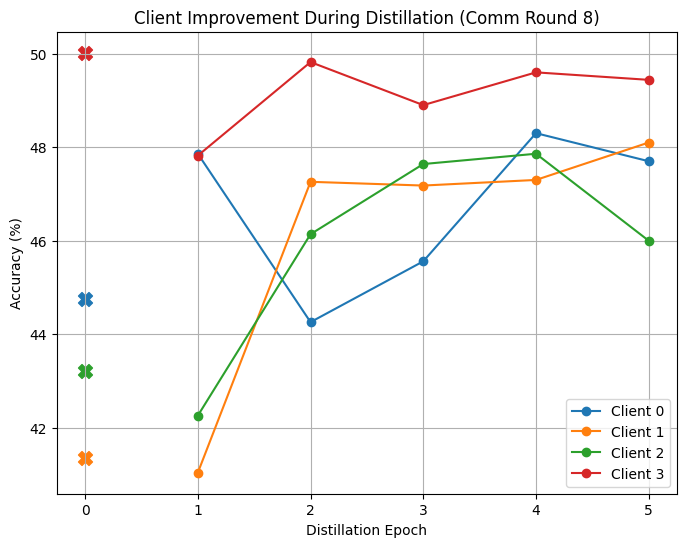


==================== COMM ROUND 9 ====================

--- LOCAL TRAINING OF CLIENTS ---

--- Client 0 Local Training ---
Client local training - Epoch [1/5], Loss: 1.0694
Client local training - Epoch [2/5], Loss: 1.0428
Client local training - Epoch [3/5], Loss: 1.0294
Client local training - Epoch [4/5], Loss: 1.0106
Client local training - Epoch [5/5], Loss: 0.9985
Client 0 Private Data Validation Accuracy: 55.70%

--- Client 1 Local Training ---
Client local training - Epoch [1/5], Loss: 0.9637
Client local training - Epoch [2/5], Loss: 0.9411
Client local training - Epoch [3/5], Loss: 0.9218
Client local training - Epoch [4/5], Loss: 0.9172
Client local training - Epoch [5/5], Loss: 0.8977
Client 1 Private Data Validation Accuracy: 64.02%

--- Client 2 Local Training ---
Client local training - Epoch [1/5], Loss: 0.8763
Client local training - Epoch [2/5], Loss: 0.8452
Client local training - Epoch [3/5], Loss: 0.8331
Client local training - Epoch [4/5], Loss: 0.8152
Client loc

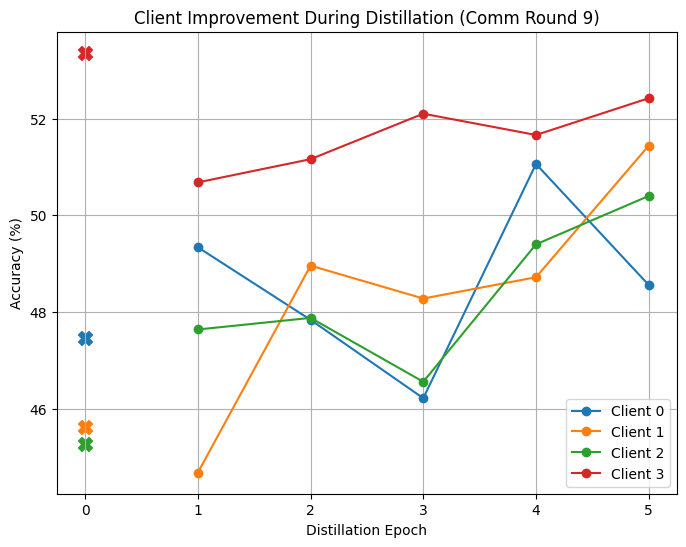


==================== COMM ROUND 10 ====================

--- LOCAL TRAINING OF CLIENTS ---

--- Client 0 Local Training ---
Client local training - Epoch [1/5], Loss: 1.0034
Client local training - Epoch [2/5], Loss: 0.9767
Client local training - Epoch [3/5], Loss: 0.9584
Client local training - Epoch [4/5], Loss: 0.9454
Client local training - Epoch [5/5], Loss: 0.9268
Client 0 Private Data Validation Accuracy: 53.86%

--- Client 1 Local Training ---
Client local training - Epoch [1/5], Loss: 0.8943
Client local training - Epoch [2/5], Loss: 0.8668
Client local training - Epoch [3/5], Loss: 0.8531
Client local training - Epoch [4/5], Loss: 0.8398
Client local training - Epoch [5/5], Loss: 0.8195
Client 1 Private Data Validation Accuracy: 62.86%

--- Client 2 Local Training ---
Client local training - Epoch [1/5], Loss: 0.8082
Client local training - Epoch [2/5], Loss: 0.7806
Client local training - Epoch [3/5], Loss: 0.7631
Client local training - Epoch [4/5], Loss: 0.7427
Client lo

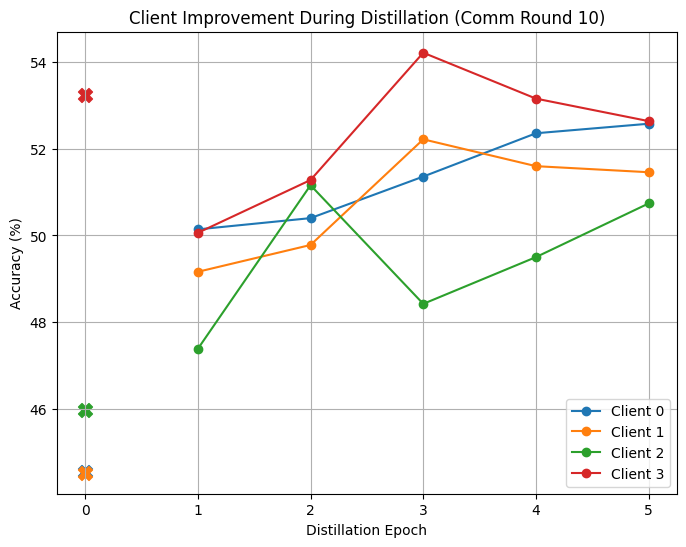

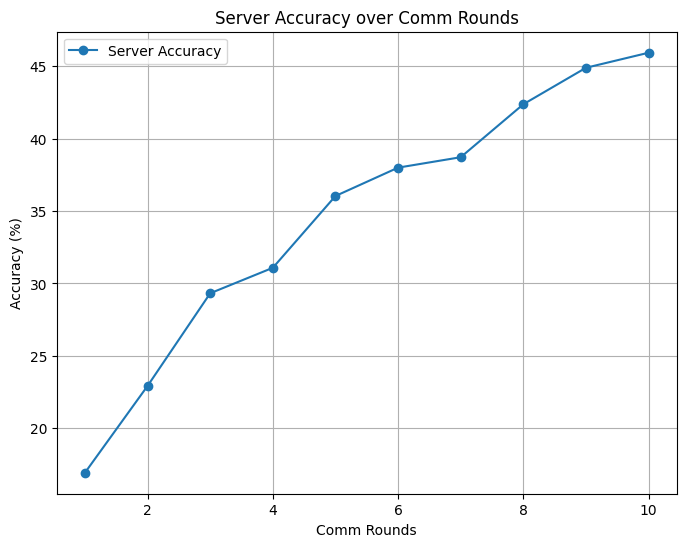

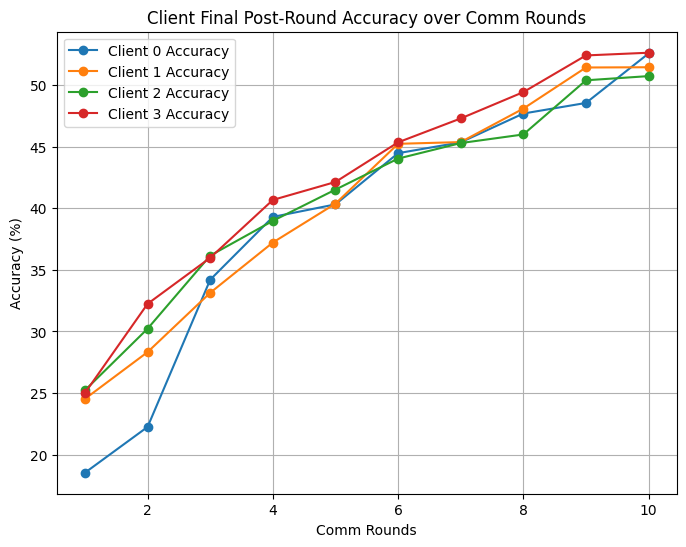


--- Clients Final Evaluation on Private Data sets ---

--- Client 0 Evaluation ---
Client 0 Final Private Data Validation Accuracy: 51.71%

--- Client 1 Evaluation ---
Client 1 Final Private Data Validation Accuracy: 51.69%

--- Client 2 Evaluation ---
Client 2 Final Private Data Validation Accuracy: 60.29%

--- Client 3 Evaluation ---
Client 3 Final Private Data Validation Accuracy: 52.63%

Final Server Test Accuracy (on Public test_set): 46.75%


In [ ]:
# Hyperparameters
BATCH_SIZE = 64
LEARNING_RATE = 0.01
DISTILLATION_CLIENT_EPOCHS = 5
NUM_EPOCHS = 5
SERVER_EPOCHS = 10
ALPHA = 1  # Dirichlet distribution concentration parameter (lower = more skewed)
NUM_OF_CLIENTS = 4
CLIENT_TEMPERATURE = 1
DISTILLATION_TEMPERATURE = 3
COMM_ROUND = 10 #the communication round

run_baseline_model()

# Model Improvement 1

In [ ]:
def run_model_improvement_1():

    client_train_loaders, client_val_loaders, server_val_loader, test_loader, client_class_distributions = load_and_partition_data()
    num_clients = len(client_train_loaders)

    # compute global class distribution from client distributions
    global_distribution = calculate_global_distribution(client_class_distributions)

    # calculate a personalized temperature for each client based on data heterogeneity scores.
    client_temperatures = []
    for i, distribution in enumerate(client_class_distributions):
        temp = calculate_client_temperature(distribution, global_distribution)
        client_temperatures.append(temp)
        print(f"Client {i} personalized training temperature: {temp:.4f}")

    global_model = SimpleCNN().to(device)
    client_models = [copy.deepcopy(global_model).to(device) for _ in range(num_clients)]

    global_optimizer = optim.SGD(global_model.parameters(), lr=LEARNING_RATE)
    client_optimizers = [optim.SGD(model.parameters(), lr=LEARNING_RATE) for model in client_models]

    round_server_acc_list = []
    round_client_acc_list = [ [] for _ in range(num_clients) ]

    for br in range(COMM_ROUND):
        print("\n" + "=" * 20 + f" COMM ROUND {br + 1} " + "=" * 20)

        print("\n--- LOCAL TRAINING OF CLIENTS ---")
        for i in range(num_clients):
            print(f"\n--- Client {i} Local Training ---")
            # use the client-specific temperature calculated earlier
            client_local_train(client_models[i], client_train_loaders[i], client_optimizers[i], client_temperatures[i], epochs=NUM_EPOCHS)
            local_acc = evaluate_model(client_models[i], client_val_loaders[i])
            print(f"Client {i} Private Data Validation Accuracy: {local_acc:.2f}%")


        clients_logits = []
        for i in range(num_clients):
            print(f"\n--- Client {i} Generating Logits on Public Data ---")# logits are collected from each client
            clients_logits.append(client_predict_logits(client_models[i], server_val_loader))


        aggregated_logits = aggregate_logits(clients_logits)# compute aggregated logits using client logits


        print("\n--- Server KD Distillation Update ---")
        # server distillation update (global model update)
        server_distillation_update(global_model, server_val_loader, aggregated_logits, global_optimizer, DISTILLATION_TEMPERATURE, epochs=SERVER_EPOCHS)
        pub_server_acc = evaluate_model(global_model, server_val_loader)
        print(f"Server Public Data Validation Accuracy: {pub_server_acc:.2f}%")
        round_server_acc_list.append(pub_server_acc)


        client_pub_pre_distillation = [] # evaluate & record clients' public data validation accuracy before client distillation update
        for i in range(num_clients):
            pre_acc = evaluate_model(client_models[i], server_val_loader)
            client_pub_pre_distillation.append(pre_acc)
            print(f"Client {i} Public Data Validation Accuracy before distillation: {pre_acc:.2f}%")


        client_epoch_progress_round = [] # each client performs a distillation update with epoch-wise progress reporting
        for i in range(num_clients):
            print(f"\n--- Client {i} Distillation Update ---")
            epoch_accs = client_distillation_update(client_models[i], server_val_loader, aggregated_logits, client_optimizers[i], DISTILLATION_TEMPERATURE, epochs=DISTILLATION_CLIENT_EPOCHS)
            client_epoch_progress_round.append(epoch_accs)
            round_client_acc_list[i].append(epoch_accs[-1])

        # plot client improvement (epoch-wise) for the round
        plt.figure(figsize=(8, 6))
        for i, epoch_accs in enumerate(client_epoch_progress_round):
            epochs_range = list(range(1, len(epoch_accs) + 1))
            line, = plt.plot(epochs_range, epoch_accs, marker='o', label=f'Client {i}')
            color = line.get_color()
            # mark the pre-distillation accuracy at epoch 0
            plt.scatter(0, client_pub_pre_distillation[i], marker='X', s=100, color=color,
                        label=f'Client {i} Pre-Distillation' if br == 0 else "")
        plt.xlabel('Distillation Epoch')
        plt.ylabel('Accuracy (%)')
        plt.title(f'Client Improvement During Distillation (Comm Round {br + 1})')
        plt.legend()
        plt.grid(True)
        plt.show()

    # plot overall server accuracy over rounds
    rounds = list(range(1, COMM_ROUND + 1))
    plt.figure(figsize=(8, 6))
    plt.plot(rounds, round_server_acc_list, marker='o', label='Server Accuracy')
    plt.xlabel('Comm Rounds')
    plt.ylabel('Accuracy (%)')
    plt.title('Server Accuracy over Comm Rounds')
    plt.legend()
    plt.grid(True)
    plt.show()

    # plot overall final post-round client accuracies over big rounds
    plt.figure(figsize=(8, 6))
    for i in range(num_clients):
        plt.plot(rounds, round_client_acc_list[i], marker='o', label=f'Client {i} Accuracy')
    plt.xlabel('Comm Rounds')
    plt.ylabel('Accuracy (%)')
    plt.title('Client Final Post-Round Accuracy over Comm Rounds')
    plt.legend()
    plt.grid(True)
    plt.show()

    print("\n--- Clients Final Evaluation on Private Data sets ---")
    for i in range(num_clients):
        print(f"\n--- Client {i} Evaluation ---")
        local_acc = evaluate_model(client_models[i], client_val_loaders[i])
        print(f"Client {i} Final Private Data Validation Accuracy: {local_acc:.2f}%")

    # final testing on external test set
    final_test_acc = evaluate_model(global_model, test_loader)
    print(f"\nFinal Server Test Accuracy (on Public test_set): {final_test_acc:.2f}%")

# Running Model Improvement 1

Files already downloaded and verified
Files already downloaded and verified
Data partitioning complete.
Client 0 class distribution:
  Class 0: 0.03
  Class 1: 0.03
  Class 2: 0.06
  Class 3: 0.29
  Class 4: 0.07
  Class 5: 0.20
  Class 6: 0.08
  Class 7: 0.17
  Class 8: 0.00
  Class 9: 0.07
Client 1 class distribution:
  Class 0: 0.23
  Class 1: 0.03
  Class 2: 0.09
  Class 3: 0.04
  Class 4: 0.16
  Class 5: 0.03
  Class 6: 0.22
  Class 7: 0.01
  Class 8: 0.16
  Class 9: 0.02
Client 2 class distribution:
  Class 0: 0.10
  Class 1: 0.01
  Class 2: 0.00
  Class 3: 0.04
  Class 4: 0.12
  Class 5: 0.08
  Class 6: 0.03
  Class 7: 0.20
  Class 8: 0.18
  Class 9: 0.23
Client 3 class distribution:
  Class 0: 0.06
  Class 1: 0.29
  Class 2: 0.21
  Class 3: 0.03
  Class 4: 0.06
  Class 5: 0.08
  Class 6: 0.08
  Class 7: 0.03
  Class 8: 0.07
  Class 9: 0.09
Client 0 personalized training temperature: 0.2892
Client 1 personalized training temperature: 0.3038
Client 2 personalized training tempera

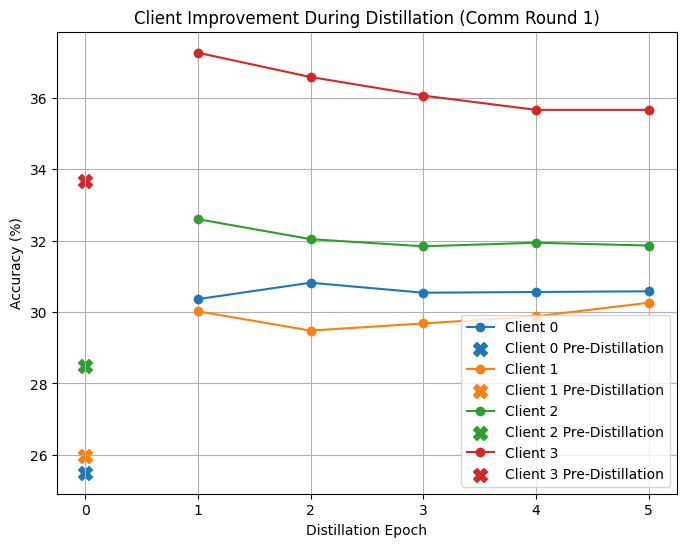


==================== COMM ROUND 2 ====================

--- LOCAL TRAINING OF CLIENTS ---

--- Client 0 Local Training ---
Client local training - Epoch [1/5], Loss: 1.5427
Client local training - Epoch [2/5], Loss: 1.4758
Client local training - Epoch [3/5], Loss: 1.4245
Client local training - Epoch [4/5], Loss: 1.3855
Client local training - Epoch [5/5], Loss: 1.3424
Client 0 Private Data Validation Accuracy: 46.01%

--- Client 1 Local Training ---
Client local training - Epoch [1/5], Loss: 1.4086
Client local training - Epoch [2/5], Loss: 1.3500
Client local training - Epoch [3/5], Loss: 1.3135
Client local training - Epoch [4/5], Loss: 1.2743
Client local training - Epoch [5/5], Loss: 1.2540
Client 1 Private Data Validation Accuracy: 37.28%

--- Client 2 Local Training ---
Client local training - Epoch [1/5], Loss: 1.3472
Client local training - Epoch [2/5], Loss: 1.2840
Client local training - Epoch [3/5], Loss: 1.2440
Client local training - Epoch [4/5], Loss: 1.2093
Client loc

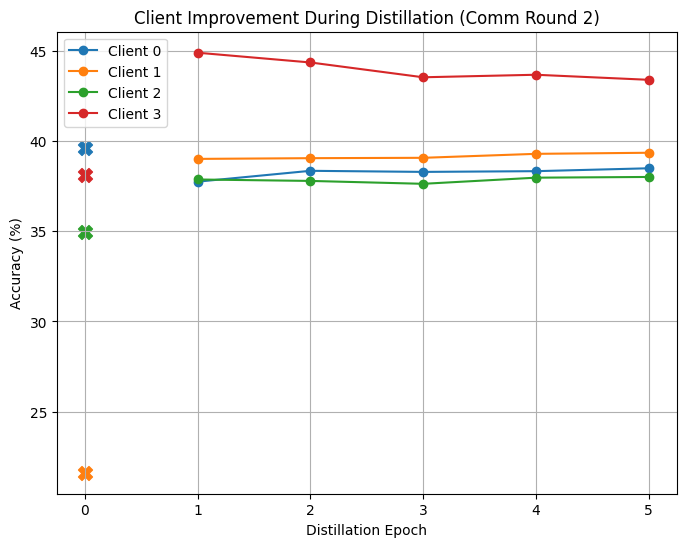


==================== COMM ROUND 3 ====================

--- LOCAL TRAINING OF CLIENTS ---

--- Client 0 Local Training ---
Client local training - Epoch [1/5], Loss: 1.3265
Client local training - Epoch [2/5], Loss: 1.2788
Client local training - Epoch [3/5], Loss: 1.2573
Client local training - Epoch [4/5], Loss: 1.2251
Client local training - Epoch [5/5], Loss: 1.1952
Client 0 Private Data Validation Accuracy: 51.40%

--- Client 1 Local Training ---
Client local training - Epoch [1/5], Loss: 1.2217
Client local training - Epoch [2/5], Loss: 1.1918
Client local training - Epoch [3/5], Loss: 1.1716
Client local training - Epoch [4/5], Loss: 1.1423
Client local training - Epoch [5/5], Loss: 1.1191
Client 1 Private Data Validation Accuracy: 57.16%

--- Client 2 Local Training ---
Client local training - Epoch [1/5], Loss: 1.1580
Client local training - Epoch [2/5], Loss: 1.1070
Client local training - Epoch [3/5], Loss: 1.0869
Client local training - Epoch [4/5], Loss: 1.0671
Client loc

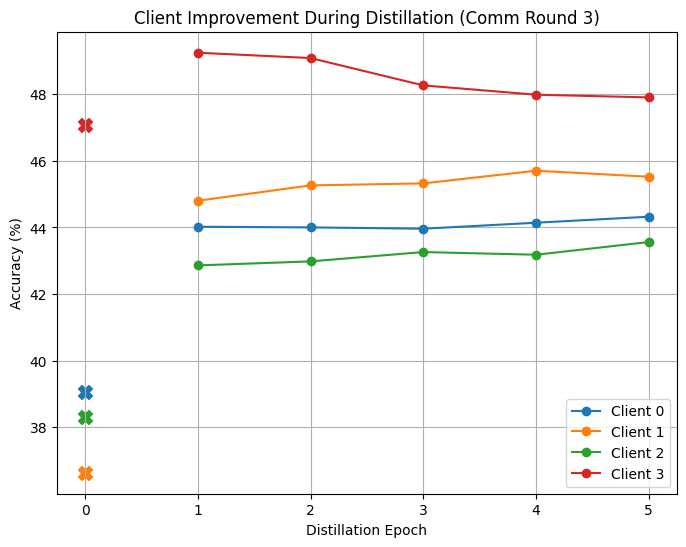


==================== COMM ROUND 4 ====================

--- LOCAL TRAINING OF CLIENTS ---

--- Client 0 Local Training ---
Client local training - Epoch [1/5], Loss: 1.1824
Client local training - Epoch [2/5], Loss: 1.1487
Client local training - Epoch [3/5], Loss: 1.1248
Client local training - Epoch [4/5], Loss: 1.0989
Client local training - Epoch [5/5], Loss: 1.0754
Client 0 Private Data Validation Accuracy: 50.26%

--- Client 1 Local Training ---
Client local training - Epoch [1/5], Loss: 1.0965
Client local training - Epoch [2/5], Loss: 1.0773
Client local training - Epoch [3/5], Loss: 1.0420
Client local training - Epoch [4/5], Loss: 1.0254
Client local training - Epoch [5/5], Loss: 0.9910
Client 1 Private Data Validation Accuracy: 54.88%

--- Client 2 Local Training ---
Client local training - Epoch [1/5], Loss: 1.0220
Client local training - Epoch [2/5], Loss: 0.9991
Client local training - Epoch [3/5], Loss: 0.9610
Client local training - Epoch [4/5], Loss: 0.9414
Client loc

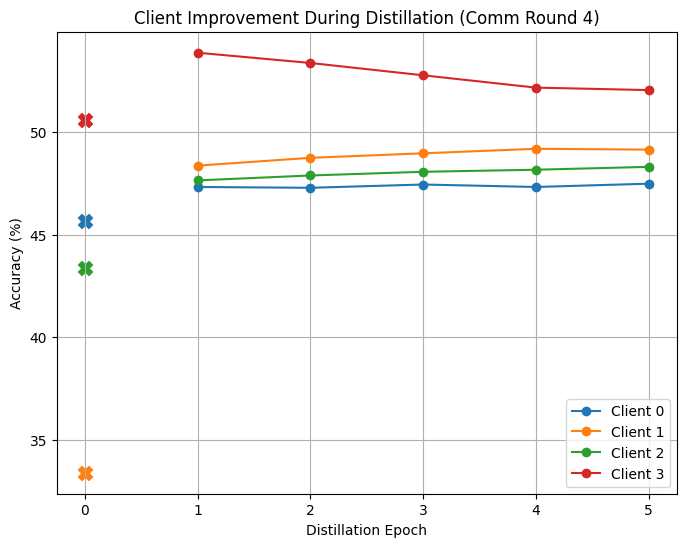


==================== COMM ROUND 5 ====================

--- LOCAL TRAINING OF CLIENTS ---

--- Client 0 Local Training ---
Client local training - Epoch [1/5], Loss: 1.0474
Client local training - Epoch [2/5], Loss: 1.0270
Client local training - Epoch [3/5], Loss: 1.0013
Client local training - Epoch [4/5], Loss: 0.9908
Client local training - Epoch [5/5], Loss: 0.9535
Client 0 Private Data Validation Accuracy: 55.04%

--- Client 1 Local Training ---
Client local training - Epoch [1/5], Loss: 0.9906
Client local training - Epoch [2/5], Loss: 0.9551
Client local training - Epoch [3/5], Loss: 0.9235
Client local training - Epoch [4/5], Loss: 0.9040
Client local training - Epoch [5/5], Loss: 0.8875
Client 1 Private Data Validation Accuracy: 62.96%

--- Client 2 Local Training ---
Client local training - Epoch [1/5], Loss: 0.8958
Client local training - Epoch [2/5], Loss: 0.8715
Client local training - Epoch [3/5], Loss: 0.8487
Client local training - Epoch [4/5], Loss: 0.8191
Client loc

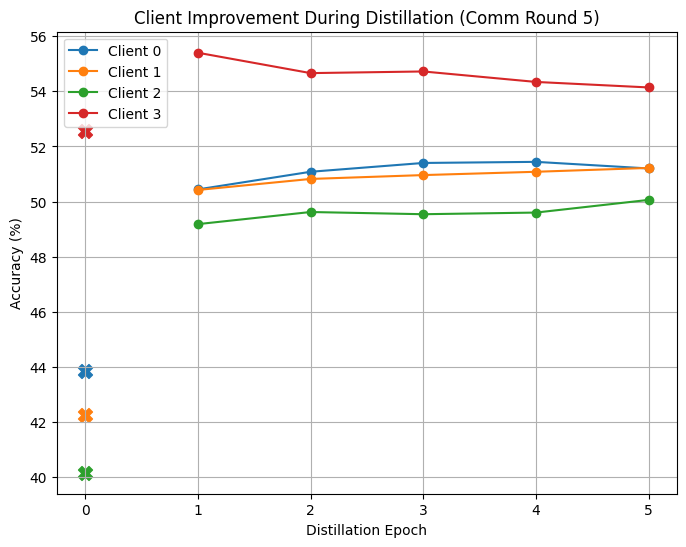


==================== COMM ROUND 6 ====================

--- LOCAL TRAINING OF CLIENTS ---

--- Client 0 Local Training ---
Client local training - Epoch [1/5], Loss: 0.9264
Client local training - Epoch [2/5], Loss: 0.9080
Client local training - Epoch [3/5], Loss: 0.8828
Client local training - Epoch [4/5], Loss: 0.8613
Client local training - Epoch [5/5], Loss: 0.8302
Client 0 Private Data Validation Accuracy: 55.43%

--- Client 1 Local Training ---
Client local training - Epoch [1/5], Loss: 0.8575
Client local training - Epoch [2/5], Loss: 0.8339
Client local training - Epoch [3/5], Loss: 0.8244
Client local training - Epoch [4/5], Loss: 0.7893
Client local training - Epoch [5/5], Loss: 0.7627
Client 1 Private Data Validation Accuracy: 62.57%

--- Client 2 Local Training ---
Client local training - Epoch [1/5], Loss: 0.7790
Client local training - Epoch [2/5], Loss: 0.7605
Client local training - Epoch [3/5], Loss: 0.7358
Client local training - Epoch [4/5], Loss: 0.7238
Client loc

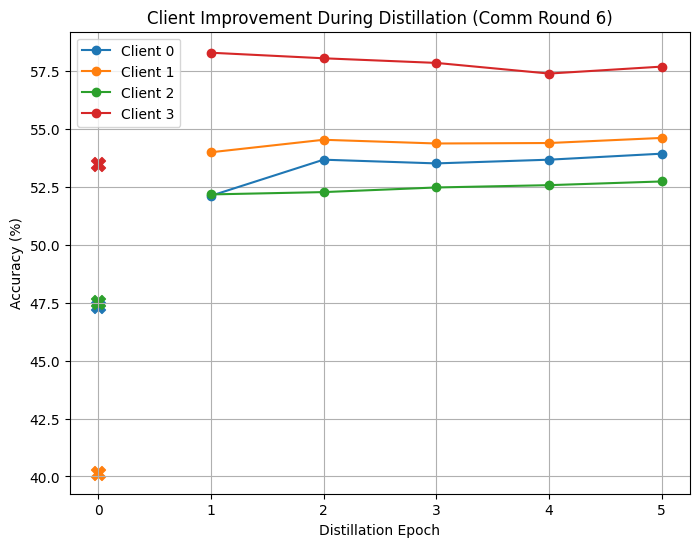


==================== COMM ROUND 7 ====================

--- LOCAL TRAINING OF CLIENTS ---

--- Client 0 Local Training ---
Client local training - Epoch [1/5], Loss: 0.8060
Client local training - Epoch [2/5], Loss: 0.7714
Client local training - Epoch [3/5], Loss: 0.7514
Client local training - Epoch [4/5], Loss: 0.7223
Client local training - Epoch [5/5], Loss: 0.6900
Client 0 Private Data Validation Accuracy: 58.28%

--- Client 1 Local Training ---
Client local training - Epoch [1/5], Loss: 0.7468
Client local training - Epoch [2/5], Loss: 0.7118
Client local training - Epoch [3/5], Loss: 0.6995
Client local training - Epoch [4/5], Loss: 0.6794
Client local training - Epoch [5/5], Loss: 0.6557
Client 1 Private Data Validation Accuracy: 66.30%

--- Client 2 Local Training ---
Client local training - Epoch [1/5], Loss: 0.6728
Client local training - Epoch [2/5], Loss: 0.6538
Client local training - Epoch [3/5], Loss: 0.6287
Client local training - Epoch [4/5], Loss: 0.6006
Client loc

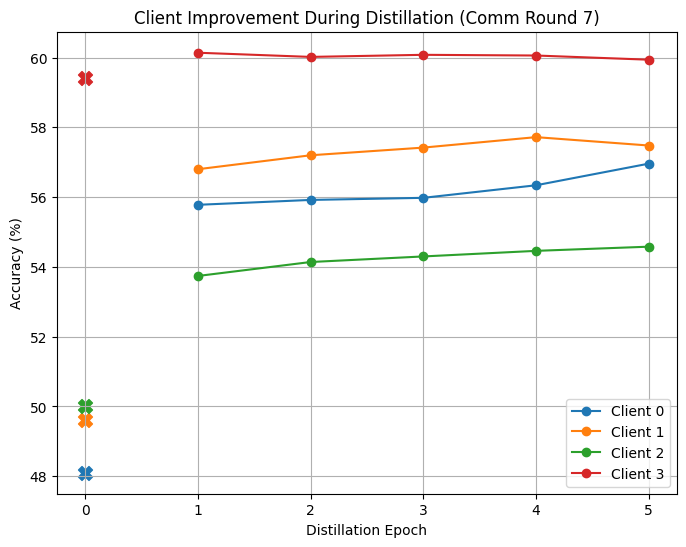


==================== COMM ROUND 8 ====================

--- LOCAL TRAINING OF CLIENTS ---

--- Client 0 Local Training ---
Client local training - Epoch [1/5], Loss: 0.6773
Client local training - Epoch [2/5], Loss: 0.6423
Client local training - Epoch [3/5], Loss: 0.6061
Client local training - Epoch [4/5], Loss: 0.5716
Client local training - Epoch [5/5], Loss: 0.5456
Client 0 Private Data Validation Accuracy: 54.08%

--- Client 1 Local Training ---
Client local training - Epoch [1/5], Loss: 0.6227
Client local training - Epoch [2/5], Loss: 0.6084
Client local training - Epoch [3/5], Loss: 0.5868
Client local training - Epoch [4/5], Loss: 0.5649
Client local training - Epoch [5/5], Loss: 0.5340
Client 1 Private Data Validation Accuracy: 66.10%

--- Client 2 Local Training ---
Client local training - Epoch [1/5], Loss: 0.5787
Client local training - Epoch [2/5], Loss: 0.5524
Client local training - Epoch [3/5], Loss: 0.5386
Client local training - Epoch [4/5], Loss: 0.5111
Client loc

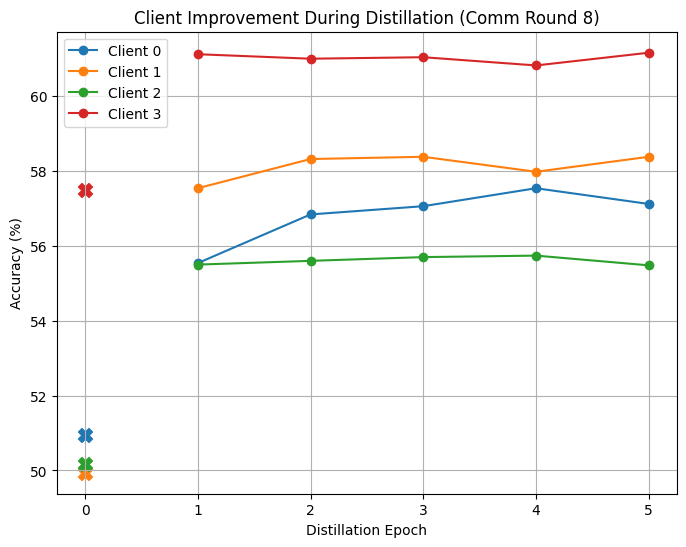


==================== COMM ROUND 9 ====================

--- LOCAL TRAINING OF CLIENTS ---

--- Client 0 Local Training ---
Client local training - Epoch [1/5], Loss: 0.5226
Client local training - Epoch [2/5], Loss: 0.4943
Client local training - Epoch [3/5], Loss: 0.4679
Client local training - Epoch [4/5], Loss: 0.4390
Client local training - Epoch [5/5], Loss: 0.4114
Client 0 Private Data Validation Accuracy: 57.67%

--- Client 1 Local Training ---
Client local training - Epoch [1/5], Loss: 0.5198
Client local training - Epoch [2/5], Loss: 0.4857
Client local training - Epoch [3/5], Loss: 0.4677
Client local training - Epoch [4/5], Loss: 0.4536
Client local training - Epoch [5/5], Loss: 0.4277
Client 1 Private Data Validation Accuracy: 68.04%

--- Client 2 Local Training ---
Client local training - Epoch [1/5], Loss: 0.4730
Client local training - Epoch [2/5], Loss: 0.4479
Client local training - Epoch [3/5], Loss: 0.4308
Client local training - Epoch [4/5], Loss: 0.4061
Client loc

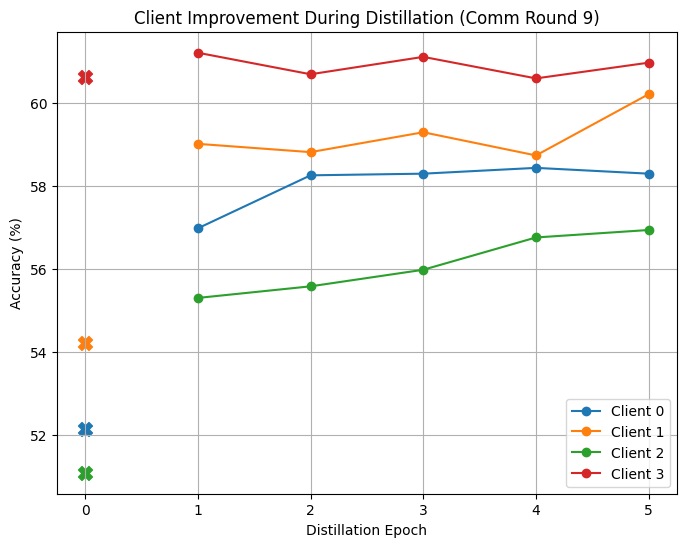


==================== COMM ROUND 10 ====================

--- LOCAL TRAINING OF CLIENTS ---

--- Client 0 Local Training ---
Client local training - Epoch [1/5], Loss: 0.3831
Client local training - Epoch [2/5], Loss: 0.3643
Client local training - Epoch [3/5], Loss: 0.3229
Client local training - Epoch [4/5], Loss: 0.3022
Client local training - Epoch [5/5], Loss: 0.2815
Client 0 Private Data Validation Accuracy: 57.98%

--- Client 1 Local Training ---
Client local training - Epoch [1/5], Loss: 0.4055
Client local training - Epoch [2/5], Loss: 0.3845
Client local training - Epoch [3/5], Loss: 0.3551
Client local training - Epoch [4/5], Loss: 0.3485
Client local training - Epoch [5/5], Loss: 0.3135
Client 1 Private Data Validation Accuracy: 68.38%

--- Client 2 Local Training ---
Client local training - Epoch [1/5], Loss: 0.3724
Client local training - Epoch [2/5], Loss: 0.3489
Client local training - Epoch [3/5], Loss: 0.3187
Client local training - Epoch [4/5], Loss: 0.2992
Client lo

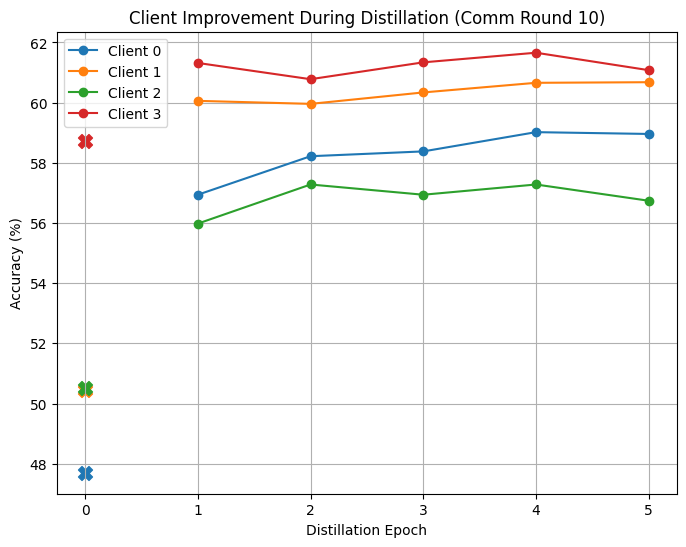

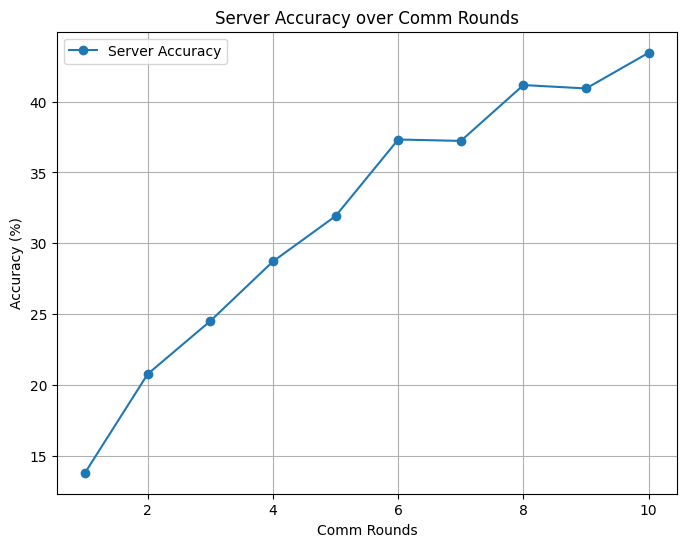

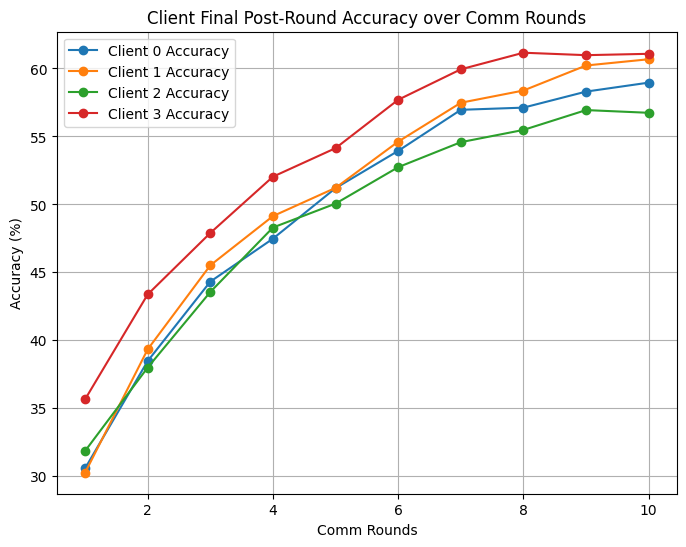


--- Clients Final Evaluation on Private Data sets ---

--- Client 0 Evaluation ---
Client 0 Final Private Data Validation Accuracy: 58.11%

--- Client 1 Evaluation ---
Client 1 Final Private Data Validation Accuracy: 64.41%

--- Client 2 Evaluation ---
Client 2 Final Private Data Validation Accuracy: 68.51%

--- Client 3 Evaluation ---
Client 3 Final Private Data Validation Accuracy: 60.38%

Final Server Test Accuracy (on Public test_set): 43.88%


In [ ]:
# Hyperparameters
BATCH_SIZE = 64
LEARNING_RATE = 0.01
DISTILLATION_CLIENT_EPOCHS = 5
NUM_EPOCHS = 5
SERVER_EPOCHS = 10
ALPHA = 1  # Dirichlet distribution concentration parameter (lower = more skewed)
NUM_OF_CLIENTS = 4
DISTILLATION_TEMPERATURE = 3
COMM_ROUND = 10 #the communication round

run_model_improvement_1()

# Results

---

| Metric                                               | Baseline Model         (T_soft = 1)         | Improvement 1 Model            |
|------------------------------------------------------|----------------------------------|--------------------------------|
| **Client 0 - Public Validation Accuracy**             | 52.58%                           | 58.96%                         |
| **Client 1 - Public Validation Accuracy**             | 51.46%                           | 60.68%                         |
| **Client 2 - Public Validation Accuracy**             | 50.74%                           | 56.74%                         |
| **Client 3 - Public Validation Accuracy**             | 52.64%                           | 61.08%                         |
| **Client 0 - Private Data Accuracy**                 | 51.71%                           | 58.11%                         |
| **Client 1 - Private Data Accuracy**                 | 51.69%                           | 64.41%                         |
| **Client 2 - Private Data Accuracy**                 | 60.29%                           | 68.51%                         |
| **Client 3 - Private Data Accuracy**                 | 52.63%                           | 60.38%                         |
| **Final Server Test Accuracy (on Public Test-Set)**  | 46.75%                           | 43.88%                         |

**Note:** Temps calculated via respective heterogneity scores of clients. Lower temp corresponds to a higher heterogeneity score.

Client 0 T_soft: 0.2892

Client 1 T_soft: 0.3038

Client 2 T_soft: 0.3477

Client 3 T_soft: 0.3424

---

## Rationale for Model Improvement 1

In the baseline federated learning pipeline, clients experienced suboptimal local validation accuracies, which limited the effectiveness of global model distillation and aggregation. To address this, we propose a unique take on the **logit chilling** technique, adapted from the *FLex&Chill framework. This method applies a softmax temperature *T* between 0 and 1 during local training to sharpen output distributions and amplify confident predictions. The other innovative angle of our approach is that the original paper applies this technique to an FL based setting, whereas we propose to leverage it for a bidirectional federated k.d pipeline, which is something that isn't found in contemporary literature.

*"Lower softmax temperatures help propagate stronger gradients to earlier network layers, enabling more effective representation learning—especially under non-i.i.d. client data conditions. Empirical studies have shown that using chilled logits can accelerate model convergence by up to 6× and improve inference accuracy by up to 3.37% compared to standard training with *T* = 1. Additionally, experiments across datasets such as FEMNIST-DNN, CIFAR10-CNN, and CIFAR100-ResNet18 demonstrated consistent gains in average client-side accuracy when using *T* < 1 during local training." ~ Lee et al.*

Building on these findings, we implemented a **curriculum-based** personalized learning mechanism based on each client’s data heterogeneity. Each client chills its logits according to its class distribution divergence, ensuring adaptive training aligned with local data characteristics. This dynamic approach also supports stable convergence and better accommodates heterogeneous data settings as in our case.

In our experiments, this personalized logit chilling strategy led to notable improvements in the accuracies on the local-training data across clients, which outperformed the baseline implementation significantly. Overall, integrating logit chilling into Model Improvement 1 leverages theoretical insights and proven empirical benefits to overcome baseline limitations and boost federated learning performance.

(please see section below for citation information)

## Building on the Framework; Motivation for Second Improvement

-  One challenge that emerged from this model improvement was a **decrease in public data accuracy for the server model**, despite the fact that client models became more accurate. Specifically, we observed an average **drop of 3% in server model accuracy** on the public dataset. This indicates that while clients benefited from sharper local predictions (which is essential for making the learning at server-side more comprehensive and inclusive of the precise details encountered at each clients end), the global model may not have been learning as effectively from the aggregated updates. We shall investigate why this is happening in our second improvemnet, but we have strong theoretical evidence that supports the idea that this "adaptive logit-chilling" should benefit both the clients (which it is greatly right now), but the server as well. This is because sharper (low‐entropy) logits concentrate probability mass on the correct class, providing a stronger learning signal that emphasizes the most important decision boundaries. This helps the global model learn precise distinctions that might otherwise be washed out by overly soft targets. So aggregating these detailed, confident outputs yields a richer supervisory signal for the server, improving its performance on a balanced proxy set and enhancing its robustness to class‐imbalance drift. In our second iteration, we aim to address this by improving server model generalization so it performs better on public data set and can actually take advantage of the improved client models.

-  **Why personalised approach?** Why did we use heterogeneity to scale temperatures and make learning personalised? Why didn't we instead use a fixed temperature score during logit chilling phase of our pipeline? In the FLex&Chill framework: it is stated that in iid settings using lower temperatures does not make much of a difference, but it actually works better in a non iid setting. The authors were using a fixed temperature for logit chilling whereas we have kept our adaptive, the reason for that is if some proportion of our clients had partitions which were iid, then using a very low temperature could have hindered the learning of our global server model and logit chilling wouldn't have had any effect on our results, whereas in our current pipeline, if any client does supposedly get an iid partition, then our personalised temperature scheduling automatically accounts for this and assigns a temperature closer to 1 for such a client during its local training phase (on its private data). This will be investigated further as well, but our claim is our curriculum based learning approach will be more robust to different settings of iid/non-iid degrees compared to the original paper.


**Citations:**

- [Improving Local Training in Federated Learning via Temperature Scaling – Lee, Kim, and Ko](https://arxiv.org/pdf/2401.09986v2)

- [Distilling the Knowledge in a Neural Network – Hinton et al.](https://arxiv.org/pdf/1503.02531)

- [LTD: Low Temperature Distillation for Robust Adversarial Training – Chen et al.](https://arxiv.org/pdf/2111.02331)

- [FedBalancer: Data and Pace Control for Efficient Federated Learning on Heterogeneous Clients – Shin et al.](https://arxiv.org/abs/2201.01601)

- We used some recent surveys from 2024-25 pertaining to FedKD as well to do our research


---

# Model Improvement 2

In [5]:
def run_model_improvement_2():

    client_train_loaders, client_val_loaders, server_val_loader, test_loader, client_class_distributions = load_and_partition_data()
    num_clients = len(client_train_loaders)

    # compute global class distribution from client distributions
    global_distribution = calculate_global_distribution(client_class_distributions)

    # calculate a personalized temperature for each client based on data heterogeneity scores.
    client_temperatures = []
    for i, distribution in enumerate(client_class_distributions):
        temp = calculate_client_temperature(distribution, global_distribution)
        client_temperatures.append(temp)
        print(f"Client {i} personalized training temperature: {temp:.4f}")

    global_model = SimpleCNN().to(device)
    client_models = [copy.deepcopy(global_model).to(device) for _ in range(num_clients)]

    global_optimizer = optim.SGD(global_model.parameters(), lr=LEARNING_RATE)
    client_optimizers = [optim.SGD(model.parameters(), lr=LEARNING_RATE) for model in client_models]

    round_server_acc_list = []
    round_client_acc_list = [ [] for _ in range(num_clients) ]

    for br in range(COMM_ROUND):
        print("\n" + "=" * 20 + f" COMM ROUND {br + 1} " + "=" * 20)

        print("\n--- LOCAL TRAINING OF CLIENTS ---")
        for i in range(num_clients):
            print(f"\n--- Client {i} Local Training ---")
            # use the client-specific temperature calculated earlier
            client_local_train(client_models[i], client_train_loaders[i], client_optimizers[i], client_temperatures[i], epochs=NUM_EPOCHS)
            local_acc = evaluate_model(client_models[i], client_val_loaders[i])
            print(f"Client {i} Private Data Validation Accuracy: {local_acc:.2f}%")


        clients_logits = []
        for i in range(num_clients):
            print(f"\n--- Client {i} Generating Logits on Public Data ---")# logits are collected from each client
            clients_logits.append(client_predict_logits(client_models[i], server_val_loader))


        aggregated_logits = aggregate_logits_standardized(clients_logits)# compute aggregated logits using client logits


        print("\n--- Server KD Distillation Update ---")
        # server distillation update (global model update)
        server_distillation_update_standardized(global_model, server_val_loader, aggregated_logits, global_optimizer, DISTILLATION_TEMPERATURE, epochs=SERVER_EPOCHS)
        pub_server_acc = evaluate_model(global_model, server_val_loader)
        print(f"Server Public Data Validation Accuracy: {pub_server_acc:.2f}%")
        round_server_acc_list.append(pub_server_acc)


        client_pub_pre_distillation = [] # evaluate & record clients' public data validation accuracy before client distillation update
        for i in range(num_clients):
            pre_acc = evaluate_model(client_models[i], server_val_loader)
            client_pub_pre_distillation.append(pre_acc)
            print(f"Client {i} Public Data Validation Accuracy before distillation: {pre_acc:.2f}%")


        client_epoch_progress_round = [] # each client performs a distillation update with epoch-wise progress reporting
        for i in range(num_clients):
            print(f"\n--- Client {i} Distillation Update ---")
            epoch_accs = client_distillation_update_standardized(client_models[i], server_val_loader, aggregated_logits, client_optimizers[i], DISTILLATION_TEMPERATURE, epochs=DISTILLATION_CLIENT_EPOCHS)
            client_epoch_progress_round.append(epoch_accs)
            round_client_acc_list[i].append(epoch_accs[-1])

        # plot client improvement (epoch-wise) for the round
        plt.figure(figsize=(8, 6))
        for i, epoch_accs in enumerate(client_epoch_progress_round):
            epochs_range = list(range(1, len(epoch_accs) + 1))
            line, = plt.plot(epochs_range, epoch_accs, marker='o', label=f'Client {i}')
            color = line.get_color()
            # mark the pre-distillation accuracy at epoch 0
            plt.scatter(0, client_pub_pre_distillation[i], marker='X', s=100, color=color,
                        label=f'Client {i} Pre-Distillation' if br == 0 else "")
        plt.xlabel('Distillation Epoch')
        plt.ylabel('Accuracy (%)')
        plt.title(f'Client Improvement During Distillation (Comm Round {br + 1})')
        plt.legend()
        plt.grid(True)
        plt.show()

    # plot overall server accuracy over rounds
    rounds = list(range(1, COMM_ROUND + 1))
    plt.figure(figsize=(8, 6))
    plt.plot(rounds, round_server_acc_list, marker='o', label='Server Accuracy')
    plt.xlabel('Comm Rounds')
    plt.ylabel('Accuracy (%)')
    plt.title('Server Accuracy over Comm Rounds')
    plt.legend()
    plt.grid(True)
    plt.show()

    # plot overall final post-round client accuracies over big rounds
    plt.figure(figsize=(8, 6))
    for i in range(num_clients):
        plt.plot(rounds, round_client_acc_list[i], marker='o', label=f'Client {i} Accuracy')
    plt.xlabel('Comm Rounds')
    plt.ylabel('Accuracy (%)')
    plt.title('Client Final Post-Round Accuracy over Comm Rounds')
    plt.legend()
    plt.grid(True)
    plt.show()

    print("\n--- Clients Final Evaluation on Private Data sets ---")
    for i in range(num_clients):
        print(f"\n--- Client {i} Evaluation ---")
        local_acc = evaluate_model(client_models[i], client_val_loaders[i])
        print(f"Client {i} Final Private Data Validation Accuracy: {local_acc:.2f}%")

    # final testing on external test set
    final_test_acc = evaluate_model(global_model, test_loader)
    print(f"\nFinal Server Test Accuracy (on Public test_set): {final_test_acc:.2f}%")

# Running Model Improvement 2

100%|██████████| 170M/170M [00:03<00:00, 43.9MB/s]


Data partitioning complete.
Client 0 class distribution:
  Class 0: 0.03
  Class 1: 0.03
  Class 2: 0.06
  Class 3: 0.29
  Class 4: 0.07
  Class 5: 0.20
  Class 6: 0.08
  Class 7: 0.17
  Class 8: 0.00
  Class 9: 0.07
Client 1 class distribution:
  Class 0: 0.23
  Class 1: 0.03
  Class 2: 0.09
  Class 3: 0.04
  Class 4: 0.16
  Class 5: 0.03
  Class 6: 0.22
  Class 7: 0.01
  Class 8: 0.16
  Class 9: 0.02
Client 2 class distribution:
  Class 0: 0.10
  Class 1: 0.01
  Class 2: 0.00
  Class 3: 0.04
  Class 4: 0.12
  Class 5: 0.08
  Class 6: 0.03
  Class 7: 0.20
  Class 8: 0.18
  Class 9: 0.23
Client 3 class distribution:
  Class 0: 0.06
  Class 1: 0.29
  Class 2: 0.21
  Class 3: 0.03
  Class 4: 0.06
  Class 5: 0.08
  Class 6: 0.08
  Class 7: 0.03
  Class 8: 0.07
  Class 9: 0.09
Client 0 personalized training temperature: 0.2892
Client 1 personalized training temperature: 0.3038
Client 2 personalized training temperature: 0.3477
Client 3 personalized training temperature: 0.3424

===========

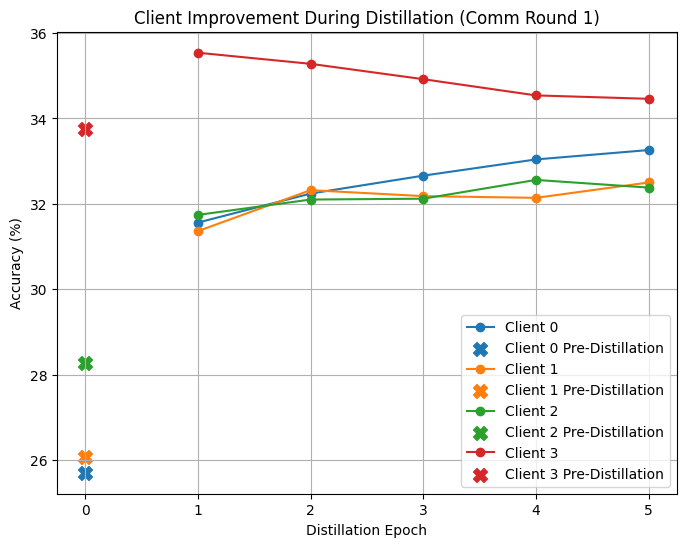


==================== COMM ROUND 2 ====================

--- LOCAL TRAINING OF CLIENTS ---

--- Client 0 Local Training ---
Client local training - Epoch [1/5], Loss: 1.5394
Client local training - Epoch [2/5], Loss: 1.4676
Client local training - Epoch [3/5], Loss: 1.4174
Client local training - Epoch [4/5], Loss: 1.3805
Client local training - Epoch [5/5], Loss: 1.3389
Client 0 Private Data Validation Accuracy: 46.67%

--- Client 1 Local Training ---
Client local training - Epoch [1/5], Loss: 1.4100
Client local training - Epoch [2/5], Loss: 1.3450
Client local training - Epoch [3/5], Loss: 1.3077
Client local training - Epoch [4/5], Loss: 1.2688
Client local training - Epoch [5/5], Loss: 1.2483
Client 1 Private Data Validation Accuracy: 39.80%

--- Client 2 Local Training ---
Client local training - Epoch [1/5], Loss: 1.3521
Client local training - Epoch [2/5], Loss: 1.2804
Client local training - Epoch [3/5], Loss: 1.2412
Client local training - Epoch [4/5], Loss: 1.2061
Client loc

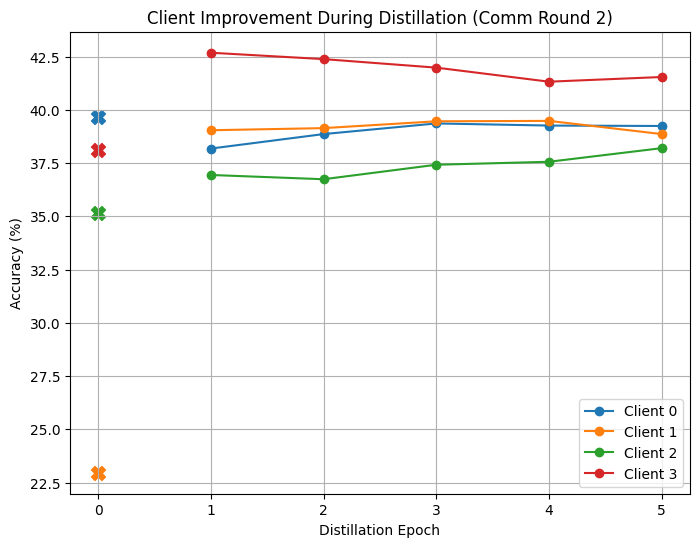


==================== COMM ROUND 3 ====================

--- LOCAL TRAINING OF CLIENTS ---

--- Client 0 Local Training ---
Client local training - Epoch [1/5], Loss: 1.3248
Client local training - Epoch [2/5], Loss: 1.2775
Client local training - Epoch [3/5], Loss: 1.2560
Client local training - Epoch [4/5], Loss: 1.2243
Client local training - Epoch [5/5], Loss: 1.1945
Client 0 Private Data Validation Accuracy: 51.31%

--- Client 1 Local Training ---
Client local training - Epoch [1/5], Loss: 1.2165
Client local training - Epoch [2/5], Loss: 1.1874
Client local training - Epoch [3/5], Loss: 1.1664
Client local training - Epoch [4/5], Loss: 1.1381
Client local training - Epoch [5/5], Loss: 1.1145
Client 1 Private Data Validation Accuracy: 57.11%

--- Client 2 Local Training ---
Client local training - Epoch [1/5], Loss: 1.1592
Client local training - Epoch [2/5], Loss: 1.1053
Client local training - Epoch [3/5], Loss: 1.0846
Client local training - Epoch [4/5], Loss: 1.0640
Client loc

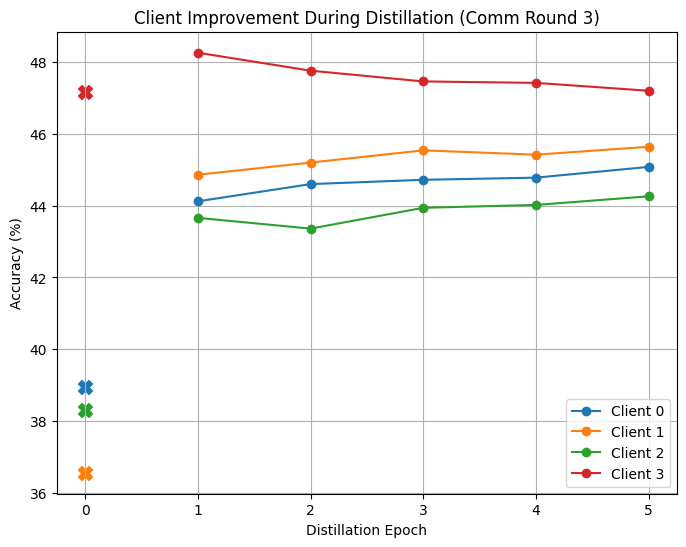


==================== COMM ROUND 4 ====================

--- LOCAL TRAINING OF CLIENTS ---

--- Client 0 Local Training ---
Client local training - Epoch [1/5], Loss: 1.1857
Client local training - Epoch [2/5], Loss: 1.1497
Client local training - Epoch [3/5], Loss: 1.1275
Client local training - Epoch [4/5], Loss: 1.1008
Client local training - Epoch [5/5], Loss: 1.0767
Client 0 Private Data Validation Accuracy: 50.00%

--- Client 1 Local Training ---
Client local training - Epoch [1/5], Loss: 1.0926
Client local training - Epoch [2/5], Loss: 1.0751
Client local training - Epoch [3/5], Loss: 1.0402
Client local training - Epoch [4/5], Loss: 1.0226
Client local training - Epoch [5/5], Loss: 0.9887
Client 1 Private Data Validation Accuracy: 54.45%

--- Client 2 Local Training ---
Client local training - Epoch [1/5], Loss: 1.0227
Client local training - Epoch [2/5], Loss: 0.9978
Client local training - Epoch [3/5], Loss: 0.9605
Client local training - Epoch [4/5], Loss: 0.9407
Client loc

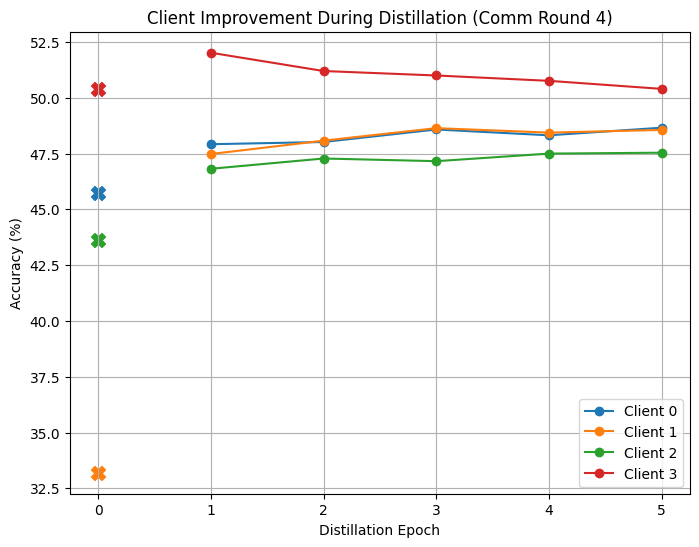


==================== COMM ROUND 5 ====================

--- LOCAL TRAINING OF CLIENTS ---

--- Client 0 Local Training ---
Client local training - Epoch [1/5], Loss: 1.0515
Client local training - Epoch [2/5], Loss: 1.0301
Client local training - Epoch [3/5], Loss: 1.0036
Client local training - Epoch [4/5], Loss: 0.9936
Client local training - Epoch [5/5], Loss: 0.9555
Client 0 Private Data Validation Accuracy: 54.95%

--- Client 1 Local Training ---
Client local training - Epoch [1/5], Loss: 0.9905
Client local training - Epoch [2/5], Loss: 0.9535
Client local training - Epoch [3/5], Loss: 0.9229
Client local training - Epoch [4/5], Loss: 0.9023
Client local training - Epoch [5/5], Loss: 0.8847
Client 1 Private Data Validation Accuracy: 63.39%

--- Client 2 Local Training ---
Client local training - Epoch [1/5], Loss: 0.8988
Client local training - Epoch [2/5], Loss: 0.8726
Client local training - Epoch [3/5], Loss: 0.8482
Client local training - Epoch [4/5], Loss: 0.8193
Client loc

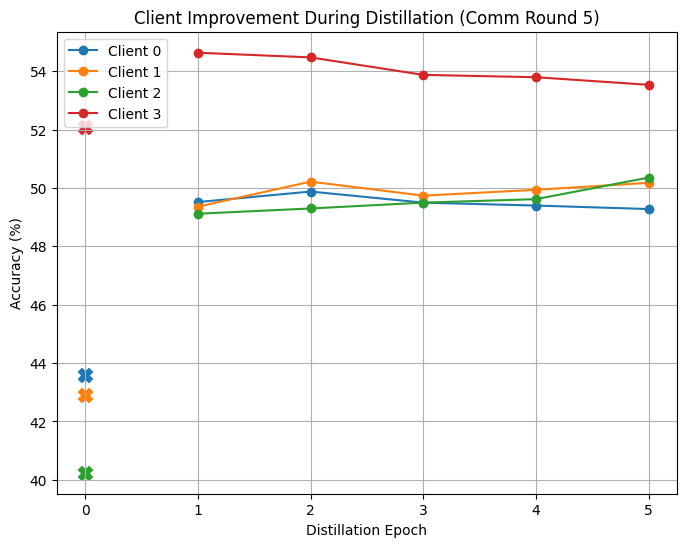


==================== COMM ROUND 6 ====================

--- LOCAL TRAINING OF CLIENTS ---

--- Client 0 Local Training ---
Client local training - Epoch [1/5], Loss: 0.9304
Client local training - Epoch [2/5], Loss: 0.9121
Client local training - Epoch [3/5], Loss: 0.8872
Client local training - Epoch [4/5], Loss: 0.8656
Client local training - Epoch [5/5], Loss: 0.8332
Client 0 Private Data Validation Accuracy: 55.48%

--- Client 1 Local Training ---
Client local training - Epoch [1/5], Loss: 0.8576
Client local training - Epoch [2/5], Loss: 0.8325
Client local training - Epoch [3/5], Loss: 0.8224
Client local training - Epoch [4/5], Loss: 0.7865
Client local training - Epoch [5/5], Loss: 0.7613
Client 1 Private Data Validation Accuracy: 63.39%

--- Client 2 Local Training ---
Client local training - Epoch [1/5], Loss: 0.7817
Client local training - Epoch [2/5], Loss: 0.7604
Client local training - Epoch [3/5], Loss: 0.7352
Client local training - Epoch [4/5], Loss: 0.7221
Client loc

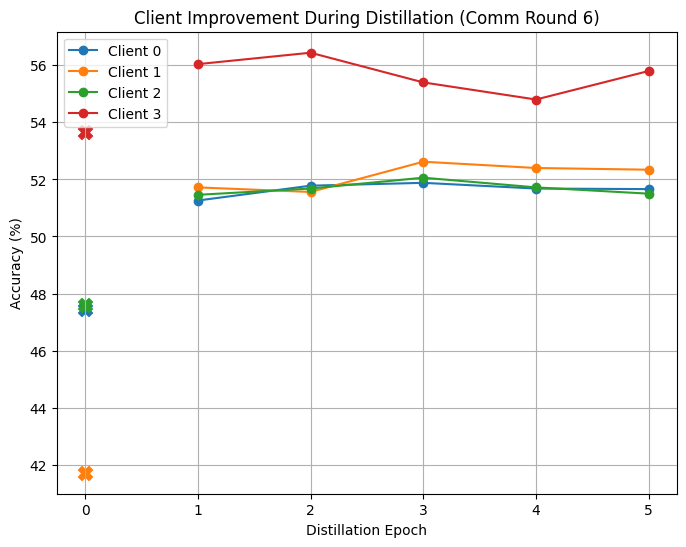


==================== COMM ROUND 7 ====================

--- LOCAL TRAINING OF CLIENTS ---

--- Client 0 Local Training ---
Client local training - Epoch [1/5], Loss: 0.8122
Client local training - Epoch [2/5], Loss: 0.7779
Client local training - Epoch [3/5], Loss: 0.7560
Client local training - Epoch [4/5], Loss: 0.7278
Client local training - Epoch [5/5], Loss: 0.6953
Client 0 Private Data Validation Accuracy: 57.36%

--- Client 1 Local Training ---
Client local training - Epoch [1/5], Loss: 0.7477
Client local training - Epoch [2/5], Loss: 0.7092
Client local training - Epoch [3/5], Loss: 0.6988
Client local training - Epoch [4/5], Loss: 0.6776
Client local training - Epoch [5/5], Loss: 0.6535
Client 1 Private Data Validation Accuracy: 66.73%

--- Client 2 Local Training ---
Client local training - Epoch [1/5], Loss: 0.6731
Client local training - Epoch [2/5], Loss: 0.6534
Client local training - Epoch [3/5], Loss: 0.6290
Client local training - Epoch [4/5], Loss: 0.6005
Client loc

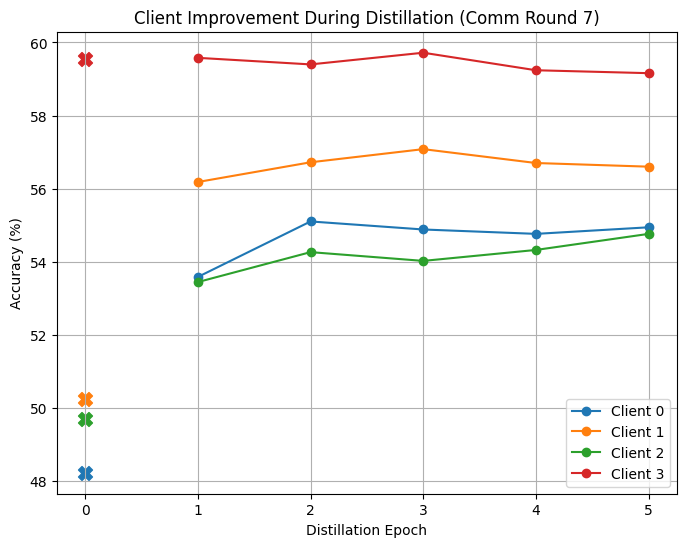


==================== COMM ROUND 8 ====================

--- LOCAL TRAINING OF CLIENTS ---

--- Client 0 Local Training ---
Client local training - Epoch [1/5], Loss: 0.6886
Client local training - Epoch [2/5], Loss: 0.6466
Client local training - Epoch [3/5], Loss: 0.6127
Client local training - Epoch [4/5], Loss: 0.5813
Client local training - Epoch [5/5], Loss: 0.5551
Client 0 Private Data Validation Accuracy: 53.90%

--- Client 1 Local Training ---
Client local training - Epoch [1/5], Loss: 0.6237
Client local training - Epoch [2/5], Loss: 0.6066
Client local training - Epoch [3/5], Loss: 0.5857
Client local training - Epoch [4/5], Loss: 0.5612
Client local training - Epoch [5/5], Loss: 0.5298
Client 1 Private Data Validation Accuracy: 66.44%

--- Client 2 Local Training ---
Client local training - Epoch [1/5], Loss: 0.5783
Client local training - Epoch [2/5], Loss: 0.5517
Client local training - Epoch [3/5], Loss: 0.5354
Client local training - Epoch [4/5], Loss: 0.5080
Client loc

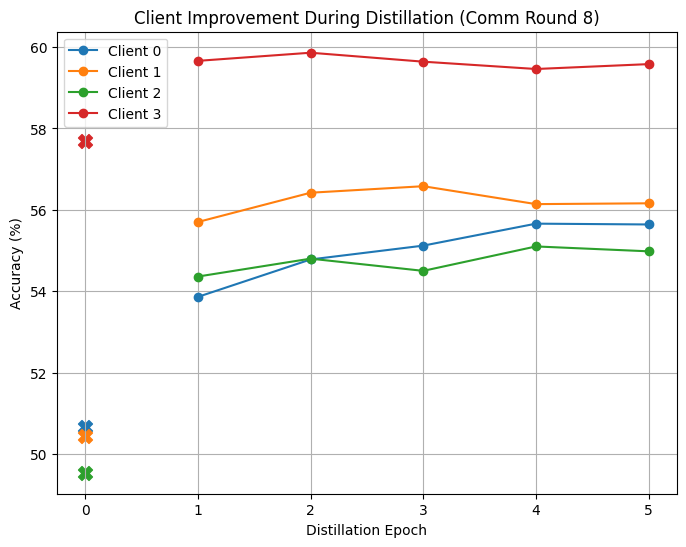


==================== COMM ROUND 9 ====================

--- LOCAL TRAINING OF CLIENTS ---

--- Client 0 Local Training ---
Client local training - Epoch [1/5], Loss: 0.5319
Client local training - Epoch [2/5], Loss: 0.5036
Client local training - Epoch [3/5], Loss: 0.4723
Client local training - Epoch [4/5], Loss: 0.4444
Client local training - Epoch [5/5], Loss: 0.4193
Client 0 Private Data Validation Accuracy: 58.41%

--- Client 1 Local Training ---
Client local training - Epoch [1/5], Loss: 0.5179
Client local training - Epoch [2/5], Loss: 0.4843
Client local training - Epoch [3/5], Loss: 0.4658
Client local training - Epoch [4/5], Loss: 0.4519
Client local training - Epoch [5/5], Loss: 0.4261
Client 1 Private Data Validation Accuracy: 68.13%

--- Client 2 Local Training ---
Client local training - Epoch [1/5], Loss: 0.4698
Client local training - Epoch [2/5], Loss: 0.4431
Client local training - Epoch [3/5], Loss: 0.4265
Client local training - Epoch [4/5], Loss: 0.4025
Client loc

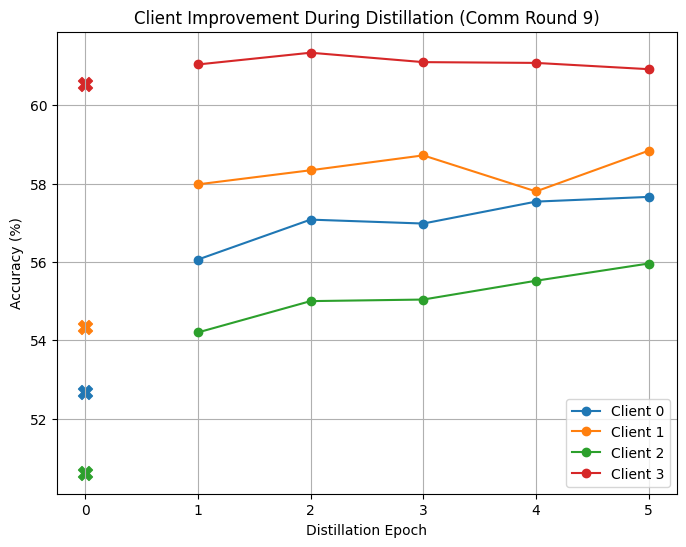


==================== COMM ROUND 10 ====================

--- LOCAL TRAINING OF CLIENTS ---

--- Client 0 Local Training ---
Client local training - Epoch [1/5], Loss: 0.3922
Client local training - Epoch [2/5], Loss: 0.3673
Client local training - Epoch [3/5], Loss: 0.3302
Client local training - Epoch [4/5], Loss: 0.3079
Client local training - Epoch [5/5], Loss: 0.2796
Client 0 Private Data Validation Accuracy: 57.19%

--- Client 1 Local Training ---
Client local training - Epoch [1/5], Loss: 0.4031
Client local training - Epoch [2/5], Loss: 0.3824
Client local training - Epoch [3/5], Loss: 0.3523
Client local training - Epoch [4/5], Loss: 0.3343
Client local training - Epoch [5/5], Loss: 0.3115
Client 1 Private Data Validation Accuracy: 69.00%

--- Client 2 Local Training ---
Client local training - Epoch [1/5], Loss: 0.3680
Client local training - Epoch [2/5], Loss: 0.3424
Client local training - Epoch [3/5], Loss: 0.3151
Client local training - Epoch [4/5], Loss: 0.2942
Client lo

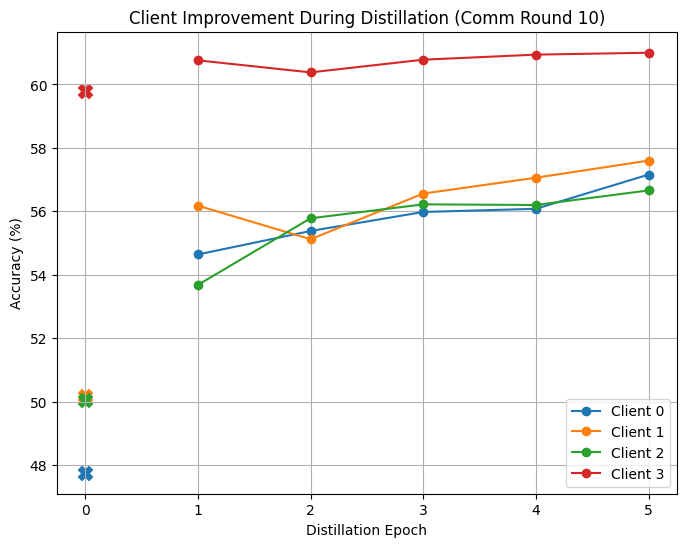

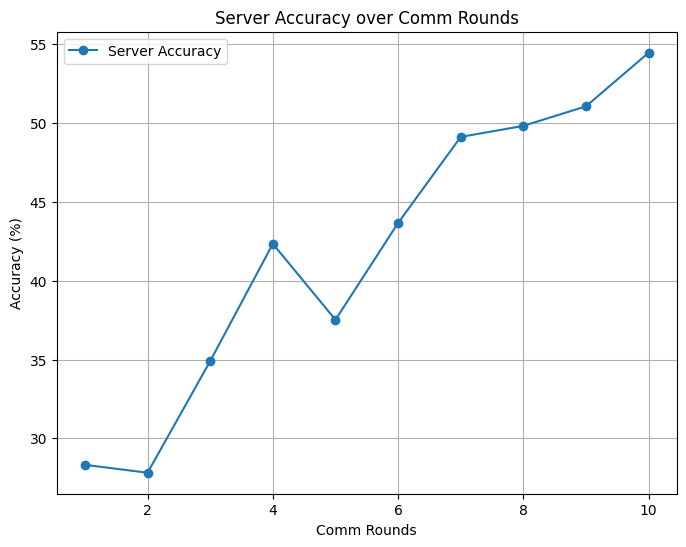

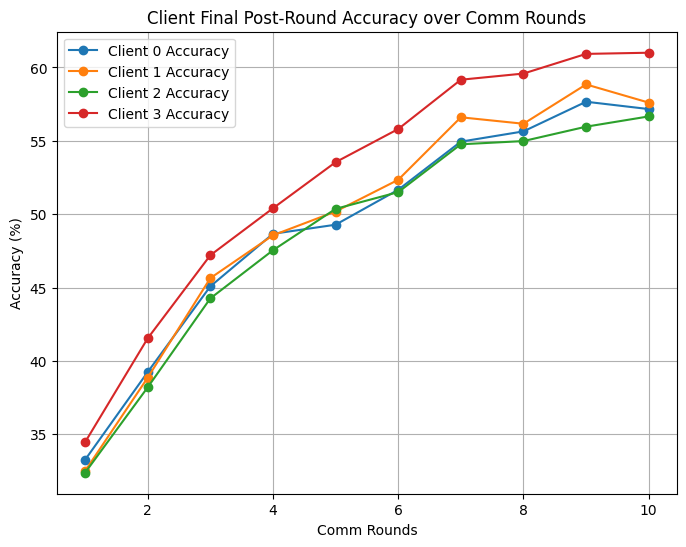


--- Clients Final Evaluation on Private Data sets ---

--- Client 0 Evaluation ---
Client 0 Final Private Data Validation Accuracy: 58.90%

--- Client 1 Evaluation ---
Client 1 Final Private Data Validation Accuracy: 64.46%

--- Client 2 Evaluation ---
Client 2 Final Private Data Validation Accuracy: 66.99%

--- Client 3 Evaluation ---
Client 3 Final Private Data Validation Accuracy: 62.41%

Final Server Test Accuracy (on Public test_set): 53.20%


In [6]:
# Hyperparameters
BATCH_SIZE = 64
LEARNING_RATE = 0.01
DISTILLATION_CLIENT_EPOCHS = 5
NUM_EPOCHS = 5
SERVER_EPOCHS = 10
ALPHA = 1  # Dirichlet distribution concentration parameter (lower = more skewed)
NUM_OF_CLIENTS = 4
DISTILLATION_TEMPERATURE = 3
COMM_ROUND = 10 #the communication round

run_model_improvement_2()

| Metric                                               | Baseline Model         (T_soft = 1)         | Improvement 1 Model            | Improvement 2 Model            |
|------------------------------------------------------|----------------------------------|--------------------------------|--------------------------------|
| **Client 0 - Public Validation Accuracy**             | 52.58%                           | 58.96%                         | 57.16%                         |
| **Client 1 - Public Validation Accuracy**             | 51.46%                           | 60.68%                         | 57.60%                         |
| **Client 2 - Public Validation Accuracy**             | 50.74%                           | 56.74%                         | 56.66%                         |
| **Client 3 - Public Validation Accuracy**             | 52.64%                           | 61.08%                         | 61.00%                         |
| **Client 0 - Private Data Accuracy**                 | 51.71%                           | 58.11%                         | 58.90%                         |
| **Client 1 - Private Data Accuracy**                 | 51.69%                           | 64.41%                         | 64.46%                         |
| **Client 2 - Private Data Accuracy**                 | 60.29%                           | 68.51%                         | 66.99%                         |
| **Client 3 - Private Data Accuracy**                 | 52.63%                           | 60.38%                         | 62.41%                         |
| **Final Server Test Accuracy (on Public Test-Set)**  | 46.75%                           | 43.88%                         | 53.20%                         |

---

# Model Improvement 2.1

## Using exponential function for scaling temperature for logit chilling

In [ ]:
def run_model_improvement_3():

    client_train_loaders, client_val_loaders, server_val_loader, test_loader, client_class_distributions = load_and_partition_data()
    num_clients = len(client_train_loaders)

    global_distribution = calculate_global_distribution(client_class_distributions)

    # calculate a personalized temperature for each client based on data heterogeneity scores.
    client_temperatures = []
    for i, distribution in enumerate(client_class_distributions):
        temp, het_score = calculate_client_temperature_EXP(distribution, global_distribution)
        client_temperatures.append(temp)
        print(f"Client {i} personalized training temperature: {temp:.4f}")
        # print(f"Client {i} het score: {het_score:.4f}")
        # print("-----")

    global_model = SimpleCNN().to(device)
    client_models = [copy.deepcopy(global_model).to(device) for _ in range(num_clients)]

    global_optimizer = optim.SGD(global_model.parameters(), lr=LEARNING_RATE)
    client_optimizers = [optim.SGD(model.parameters(), lr=LEARNING_RATE) for model in client_models]

    round_server_acc_list = []
    round_client_acc_list = [ [] for _ in range(num_clients) ]

    for br in range(COMM_ROUND):
        print("\n" + "=" * 20 + f" COMM ROUND {br + 1} " + "=" * 20)

        print("\n--- LOCAL TRAINING OF CLIENTS ---")
        for i in range(num_clients):
            print(f"\n--- Client {i} Local Training ---")
            # use the client-specific temperature calculated earlier
            client_local_train(client_models[i], client_train_loaders[i], client_optimizers[i], client_temperatures[i], epochs=NUM_EPOCHS)
            local_acc = evaluate_model(client_models[i], client_val_loaders[i])
            print(f"Client {i} Private Data Validation Accuracy: {local_acc:.2f}%")


        clients_logits = []
        for i in range(num_clients):
            print(f"\n--- Client {i} Generating Logits on Public Data ---")# logits are collected from each client
            clients_logits.append(client_predict_logits(client_models[i], server_val_loader))


        aggregated_logits = aggregate_logits_standardized(clients_logits)# compute aggregated logits using client logits


        print("\n--- Server KD Distillation Update ---")
        # server distillation update (global model update)
        server_distillation_update_standardized(global_model, server_val_loader, aggregated_logits, global_optimizer, DISTILLATION_TEMPERATURE, epochs=SERVER_EPOCHS)
        pub_server_acc = evaluate_model(global_model, server_val_loader)
        print(f"Server Public Data Validation Accuracy: {pub_server_acc:.2f}%")
        round_server_acc_list.append(pub_server_acc)


        client_pub_pre_distillation = [] # evaluate & record clients' public data validation accuracy before client distillation update
        for i in range(num_clients):
            pre_acc = evaluate_model(client_models[i], server_val_loader)
            client_pub_pre_distillation.append(pre_acc)
            print(f"Client {i} Public Data Validation Accuracy before distillation: {pre_acc:.2f}%")


        client_epoch_progress_round = [] # each client performs a distillation update with epoch-wise progress reporting
        for i in range(num_clients):
            print(f"\n--- Client {i} Distillation Update ---")
            epoch_accs = client_distillation_update_standardized(client_models[i], server_val_loader, aggregated_logits, client_optimizers[i], DISTILLATION_TEMPERATURE, epochs=DISTILLATION_CLIENT_EPOCHS)
            client_epoch_progress_round.append(epoch_accs)
            round_client_acc_list[i].append(epoch_accs[-1])

        # plot client improvement (epoch-wise) for the round
        plt.figure(figsize=(8, 6))
        for i, epoch_accs in enumerate(client_epoch_progress_round):
            epochs_range = list(range(1, len(epoch_accs) + 1))
            line, = plt.plot(epochs_range, epoch_accs, marker='o', label=f'Client {i}')
            color = line.get_color()
            # mark the pre-distillation accuracy at epoch 0
            plt.scatter(0, client_pub_pre_distillation[i], marker='X', s=100, color=color,
                        label=f'Client {i} Pre-Distillation' if br == 0 else "")
        plt.xlabel('Distillation Epoch')
        plt.ylabel('Accuracy (%)')
        plt.title(f'Client Improvement During Distillation (Comm Round {br + 1})')
        plt.legend()
        plt.grid(True)
        plt.show()

    # plot overall server accuracy over rounds
    rounds = list(range(1, COMM_ROUND + 1))
    plt.figure(figsize=(8, 6))
    plt.plot(rounds, round_server_acc_list, marker='o', label='Server Accuracy')
    plt.xlabel('Comm Rounds')
    plt.ylabel('Accuracy (%)')
    plt.title('Server Accuracy over Comm Rounds')
    plt.legend()
    plt.grid(True)
    plt.show()

    # plot overall final post-round client accuracies over big rounds
    plt.figure(figsize=(8, 6))
    for i in range(num_clients):
        plt.plot(rounds, round_client_acc_list[i], marker='o', label=f'Client {i} Accuracy')
    plt.xlabel('Comm Rounds')
    plt.ylabel('Accuracy (%)')
    plt.title('Client Final Post-Round Accuracy over Comm Rounds')
    plt.legend()
    plt.grid(True)
    plt.show()

    print("\n--- Clients Final Evaluation on Private Data sets ---")
    for i in range(num_clients):
        print(f"\n--- Client {i} Evaluation ---")
        local_acc = evaluate_model(client_models[i], client_val_loaders[i])
        print(f"Client {i} Final Private Data Validation Accuracy: {local_acc:.2f}%")

    # final testing on external test set
    final_test_acc = evaluate_model(global_model, test_loader)
    print(f"\nFinal Server Test Accuracy (on Public test_set): {final_test_acc:.2f}%")

Files already downloaded and verified
Files already downloaded and verified
Data partitioning complete.
Client 0 class distribution:
  Class 0: 0.03
  Class 1: 0.03
  Class 2: 0.06
  Class 3: 0.29
  Class 4: 0.07
  Class 5: 0.20
  Class 6: 0.08
  Class 7: 0.17
  Class 8: 0.00
  Class 9: 0.07
Client 1 class distribution:
  Class 0: 0.23
  Class 1: 0.03
  Class 2: 0.09
  Class 3: 0.04
  Class 4: 0.16
  Class 5: 0.03
  Class 6: 0.22
  Class 7: 0.01
  Class 8: 0.16
  Class 9: 0.02
Client 2 class distribution:
  Class 0: 0.10
  Class 1: 0.01
  Class 2: 0.00
  Class 3: 0.04
  Class 4: 0.12
  Class 5: 0.08
  Class 6: 0.03
  Class 7: 0.20
  Class 8: 0.18
  Class 9: 0.23
Client 3 class distribution:
  Class 0: 0.06
  Class 1: 0.29
  Class 2: 0.21
  Class 3: 0.03
  Class 4: 0.06
  Class 5: 0.08
  Class 6: 0.08
  Class 7: 0.03
  Class 8: 0.07
  Class 9: 0.09
Client 0 personalized training temperature: 0.1159
Client 1 personalized training temperature: 0.1212
Client 2 personalized training tempera

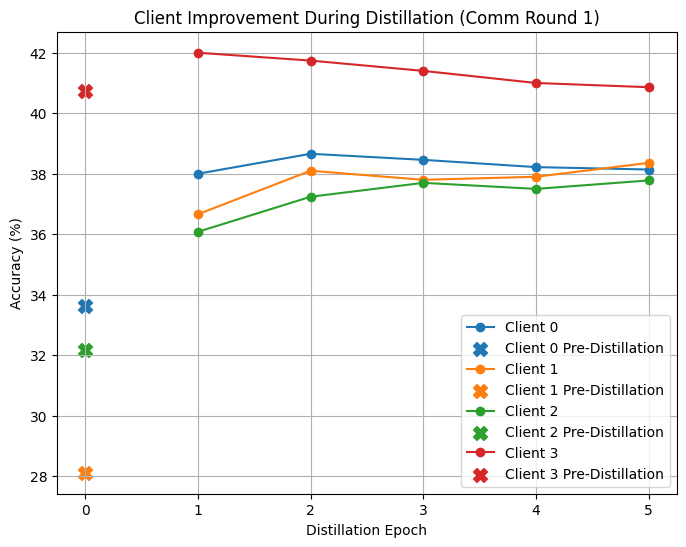


==================== COMM ROUND 2 ====================

--- LOCAL TRAINING OF CLIENTS ---

--- Client 0 Local Training ---
Client local training - Epoch [1/5], Loss: 1.3524
Client local training - Epoch [2/5], Loss: 1.2887
Client local training - Epoch [3/5], Loss: 1.2446
Client local training - Epoch [4/5], Loss: 1.2126
Client local training - Epoch [5/5], Loss: 1.1643
Client 0 Private Data Validation Accuracy: 48.99%

--- Client 1 Local Training ---
Client local training - Epoch [1/5], Loss: 1.2541
Client local training - Epoch [2/5], Loss: 1.1927
Client local training - Epoch [3/5], Loss: 1.1533
Client local training - Epoch [4/5], Loss: 1.1117
Client local training - Epoch [5/5], Loss: 1.0799
Client 1 Private Data Validation Accuracy: 42.50%

--- Client 2 Local Training ---
Client local training - Epoch [1/5], Loss: 1.1740
Client local training - Epoch [2/5], Loss: 1.1176
Client local training - Epoch [3/5], Loss: 1.0797
Client local training - Epoch [4/5], Loss: 1.0366
Client loc

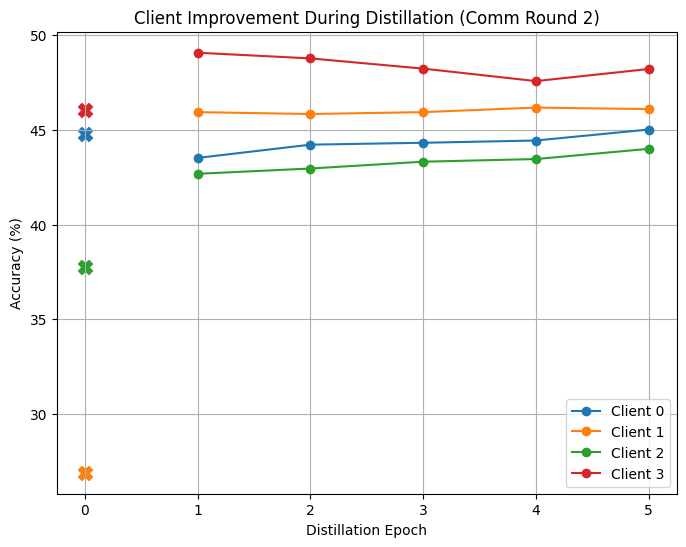


==================== COMM ROUND 3 ====================

--- LOCAL TRAINING OF CLIENTS ---

--- Client 0 Local Training ---
Client local training - Epoch [1/5], Loss: 1.1461
Client local training - Epoch [2/5], Loss: 1.0884
Client local training - Epoch [3/5], Loss: 1.0648
Client local training - Epoch [4/5], Loss: 1.0136
Client local training - Epoch [5/5], Loss: 0.9843
Client 0 Private Data Validation Accuracy: 57.36%

--- Client 1 Local Training ---
Client local training - Epoch [1/5], Loss: 1.0430
Client local training - Epoch [2/5], Loss: 1.0054
Client local training - Epoch [3/5], Loss: 0.9691
Client local training - Epoch [4/5], Loss: 0.9379
Client local training - Epoch [5/5], Loss: 0.9008
Client 1 Private Data Validation Accuracy: 62.91%

--- Client 2 Local Training ---
Client local training - Epoch [1/5], Loss: 0.9807
Client local training - Epoch [2/5], Loss: 0.9221
Client local training - Epoch [3/5], Loss: 0.8851
Client local training - Epoch [4/5], Loss: 0.8549
Client loc

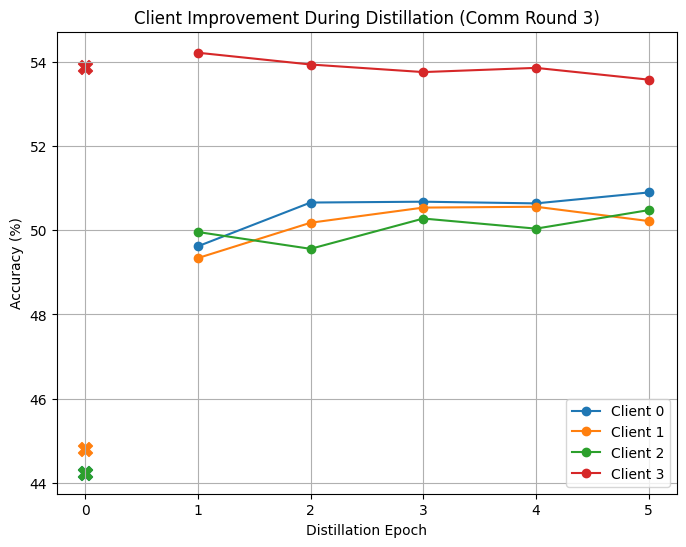


==================== COMM ROUND 4 ====================

--- LOCAL TRAINING OF CLIENTS ---

--- Client 0 Local Training ---
Client local training - Epoch [1/5], Loss: 0.9580
Client local training - Epoch [2/5], Loss: 0.9110
Client local training - Epoch [3/5], Loss: 0.8823
Client local training - Epoch [4/5], Loss: 0.8411
Client local training - Epoch [5/5], Loss: 0.8091
Client 0 Private Data Validation Accuracy: 52.63%

--- Client 1 Local Training ---
Client local training - Epoch [1/5], Loss: 0.8606
Client local training - Epoch [2/5], Loss: 0.8397
Client local training - Epoch [3/5], Loss: 0.8003
Client local training - Epoch [4/5], Loss: 0.7720
Client local training - Epoch [5/5], Loss: 0.7281
Client 1 Private Data Validation Accuracy: 56.62%

--- Client 2 Local Training ---
Client local training - Epoch [1/5], Loss: 0.8015
Client local training - Epoch [2/5], Loss: 0.7663
Client local training - Epoch [3/5], Loss: 0.7244
Client local training - Epoch [4/5], Loss: 0.6915
Client loc

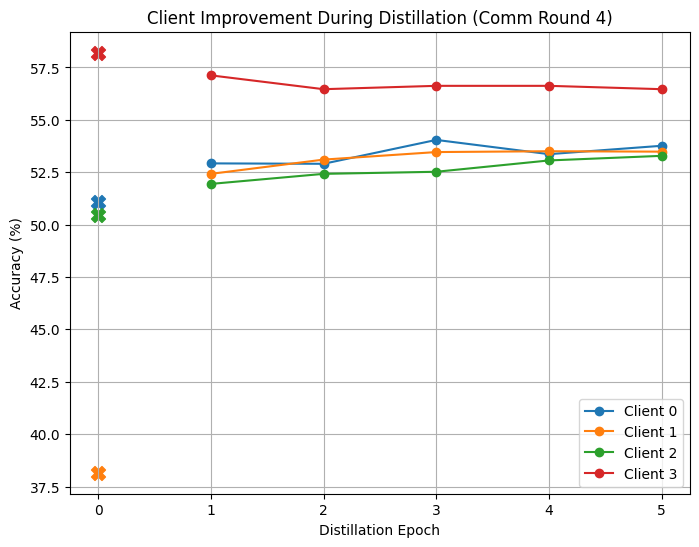


==================== COMM ROUND 5 ====================

--- LOCAL TRAINING OF CLIENTS ---

--- Client 0 Local Training ---
Client local training - Epoch [1/5], Loss: 0.7713
Client local training - Epoch [2/5], Loss: 0.7357
Client local training - Epoch [3/5], Loss: 0.6999
Client local training - Epoch [4/5], Loss: 0.6656
Client local training - Epoch [5/5], Loss: 0.6087
Client 0 Private Data Validation Accuracy: 57.67%

--- Client 1 Local Training ---
Client local training - Epoch [1/5], Loss: 0.7237
Client local training - Epoch [2/5], Loss: 0.6679
Client local training - Epoch [3/5], Loss: 0.6392
Client local training - Epoch [4/5], Loss: 0.5982
Client local training - Epoch [5/5], Loss: 0.5714
Client 1 Private Data Validation Accuracy: 65.67%

--- Client 2 Local Training ---
Client local training - Epoch [1/5], Loss: 0.6398
Client local training - Epoch [2/5], Loss: 0.6102
Client local training - Epoch [3/5], Loss: 0.5752
Client local training - Epoch [4/5], Loss: 0.5340
Client loc

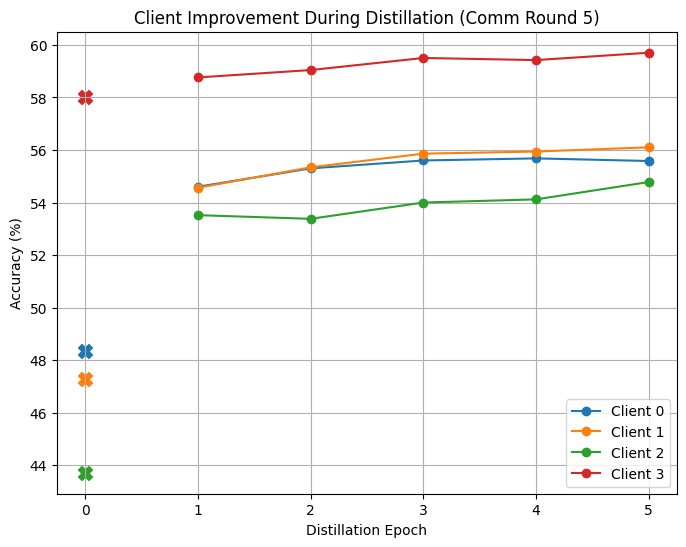


==================== COMM ROUND 6 ====================

--- LOCAL TRAINING OF CLIENTS ---

--- Client 0 Local Training ---
Client local training - Epoch [1/5], Loss: 0.5724
Client local training - Epoch [2/5], Loss: 0.5367
Client local training - Epoch [3/5], Loss: 0.5041
Client local training - Epoch [4/5], Loss: 0.4603
Client local training - Epoch [5/5], Loss: 0.4095
Client 0 Private Data Validation Accuracy: 57.01%

--- Client 1 Local Training ---
Client local training - Epoch [1/5], Loss: 0.5361
Client local training - Epoch [2/5], Loss: 0.4955
Client local training - Epoch [3/5], Loss: 0.4771
Client local training - Epoch [4/5], Loss: 0.4426
Client local training - Epoch [5/5], Loss: 0.4020
Client 1 Private Data Validation Accuracy: 57.59%

--- Client 2 Local Training ---
Client local training - Epoch [1/5], Loss: 0.4906
Client local training - Epoch [2/5], Loss: 0.4599
Client local training - Epoch [3/5], Loss: 0.4191
Client local training - Epoch [4/5], Loss: 0.4024
Client loc

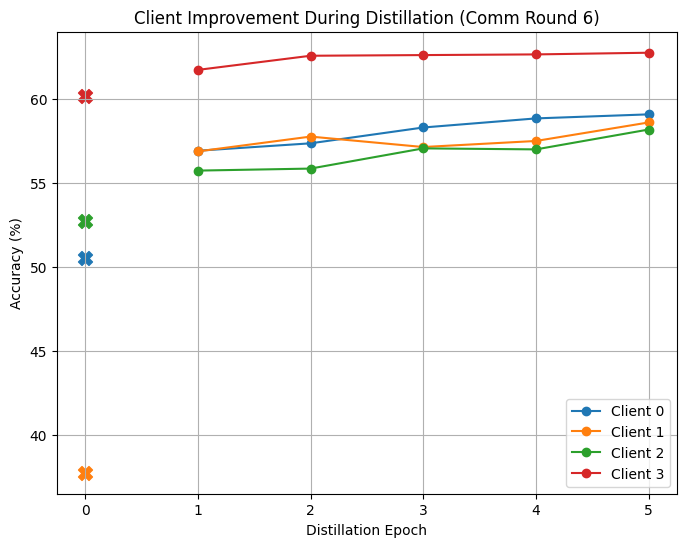


==================== COMM ROUND 7 ====================

--- LOCAL TRAINING OF CLIENTS ---

--- Client 0 Local Training ---
Client local training - Epoch [1/5], Loss: 0.3918
Client local training - Epoch [2/5], Loss: 0.3431
Client local training - Epoch [3/5], Loss: 0.3159
Client local training - Epoch [4/5], Loss: 0.2821
Client local training - Epoch [5/5], Loss: 0.2298
Client 0 Private Data Validation Accuracy: 60.74%

--- Client 1 Local Training ---
Client local training - Epoch [1/5], Loss: 0.3838
Client local training - Epoch [2/5], Loss: 0.3399
Client local training - Epoch [3/5], Loss: 0.3122
Client local training - Epoch [4/5], Loss: 0.2957
Client local training - Epoch [5/5], Loss: 0.2602
Client 1 Private Data Validation Accuracy: 69.05%

--- Client 2 Local Training ---
Client local training - Epoch [1/5], Loss: 0.3366
Client local training - Epoch [2/5], Loss: 0.3059
Client local training - Epoch [3/5], Loss: 0.2754
Client local training - Epoch [4/5], Loss: 0.2565
Client loc

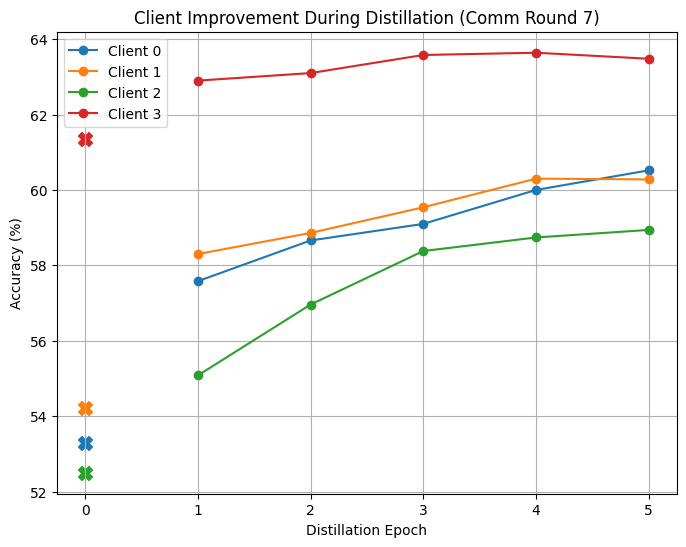


==================== COMM ROUND 8 ====================

--- LOCAL TRAINING OF CLIENTS ---

--- Client 0 Local Training ---
Client local training - Epoch [1/5], Loss: 0.2477
Client local training - Epoch [2/5], Loss: 0.1814
Client local training - Epoch [3/5], Loss: 0.1746
Client local training - Epoch [4/5], Loss: 0.1249
Client local training - Epoch [5/5], Loss: 0.1597
Client 0 Private Data Validation Accuracy: 61.09%

--- Client 1 Local Training ---
Client local training - Epoch [1/5], Loss: 0.2371
Client local training - Epoch [2/5], Loss: 0.2226
Client local training - Epoch [3/5], Loss: 0.1935
Client local training - Epoch [4/5], Loss: 0.1731
Client local training - Epoch [5/5], Loss: 0.1539
Client 1 Private Data Validation Accuracy: 70.55%

--- Client 2 Local Training ---
Client local training - Epoch [1/5], Loss: 0.2205
Client local training - Epoch [2/5], Loss: 0.1957
Client local training - Epoch [3/5], Loss: 0.1685
Client local training - Epoch [4/5], Loss: 0.1563
Client loc

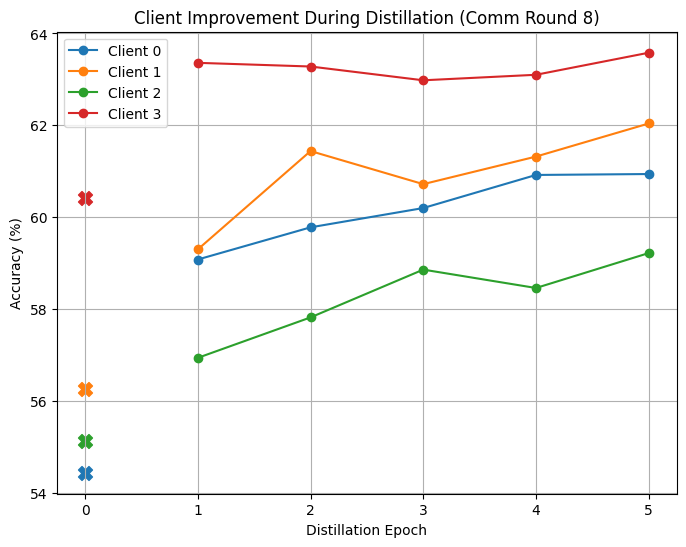


==================== COMM ROUND 9 ====================

--- LOCAL TRAINING OF CLIENTS ---

--- Client 0 Local Training ---
Client local training - Epoch [1/5], Loss: 0.1138
Client local training - Epoch [2/5], Loss: 0.0906
Client local training - Epoch [3/5], Loss: 0.0848
Client local training - Epoch [4/5], Loss: 0.0744
Client local training - Epoch [5/5], Loss: 0.0713
Client 0 Private Data Validation Accuracy: 61.09%

--- Client 1 Local Training ---
Client local training - Epoch [1/5], Loss: 0.1338
Client local training - Epoch [2/5], Loss: 0.1177
Client local training - Epoch [3/5], Loss: 0.1038
Client local training - Epoch [4/5], Loss: 0.0960
Client local training - Epoch [5/5], Loss: 0.0754
Client 1 Private Data Validation Accuracy: 67.65%

--- Client 2 Local Training ---
Client local training - Epoch [1/5], Loss: 0.1214
Client local training - Epoch [2/5], Loss: 0.1056
Client local training - Epoch [3/5], Loss: 0.0911
Client local training - Epoch [4/5], Loss: 0.0839
Client loc

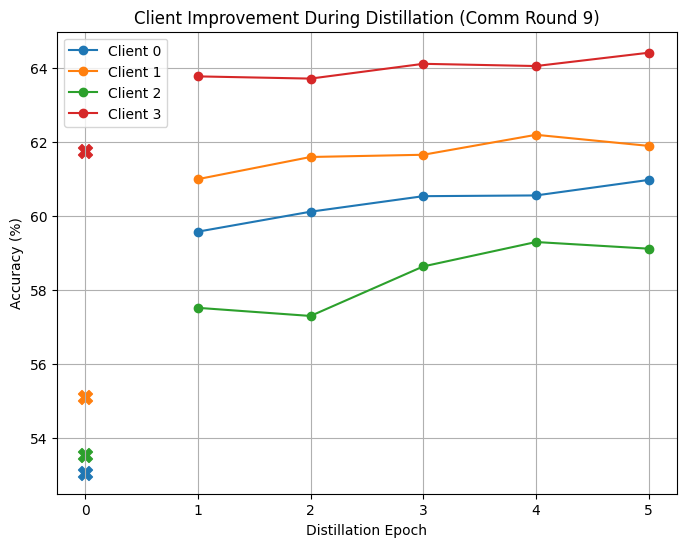


==================== COMM ROUND 10 ====================

--- LOCAL TRAINING OF CLIENTS ---

--- Client 0 Local Training ---
Client local training - Epoch [1/5], Loss: 0.0640
Client local training - Epoch [2/5], Loss: 0.0844
Client local training - Epoch [3/5], Loss: 0.0477
Client local training - Epoch [4/5], Loss: 0.0454
Client local training - Epoch [5/5], Loss: 0.0449
Client 0 Private Data Validation Accuracy: 60.74%

--- Client 1 Local Training ---
Client local training - Epoch [1/5], Loss: 0.1757
Client local training - Epoch [2/5], Loss: 0.0745
Client local training - Epoch [3/5], Loss: 0.0590
Client local training - Epoch [4/5], Loss: 0.0486
Client local training - Epoch [5/5], Loss: 0.0437
Client 1 Private Data Validation Accuracy: 71.42%

--- Client 2 Local Training ---
Client local training - Epoch [1/5], Loss: 0.1558
Client local training - Epoch [2/5], Loss: 0.0675
Client local training - Epoch [3/5], Loss: 0.0609
Client local training - Epoch [4/5], Loss: 0.0430
Client lo

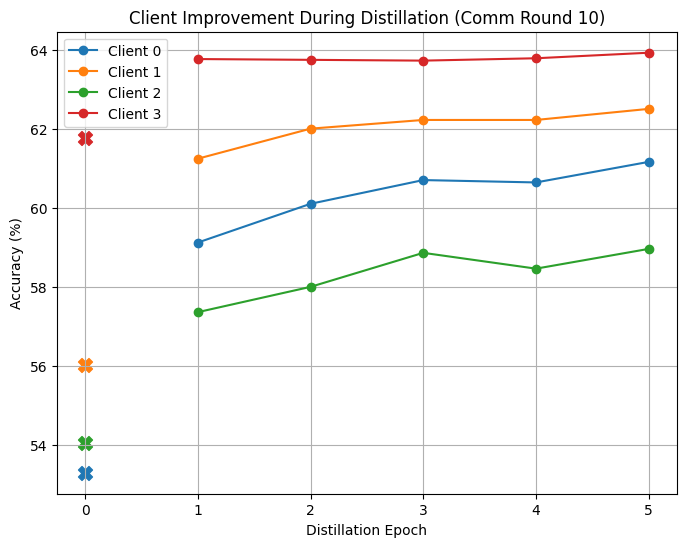

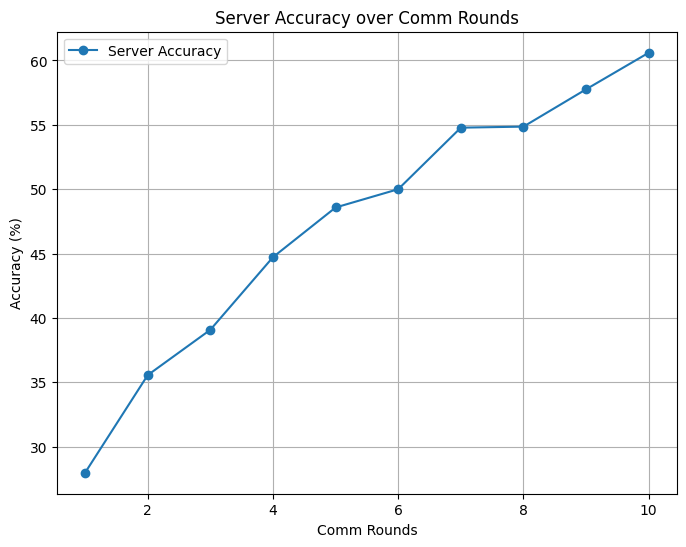

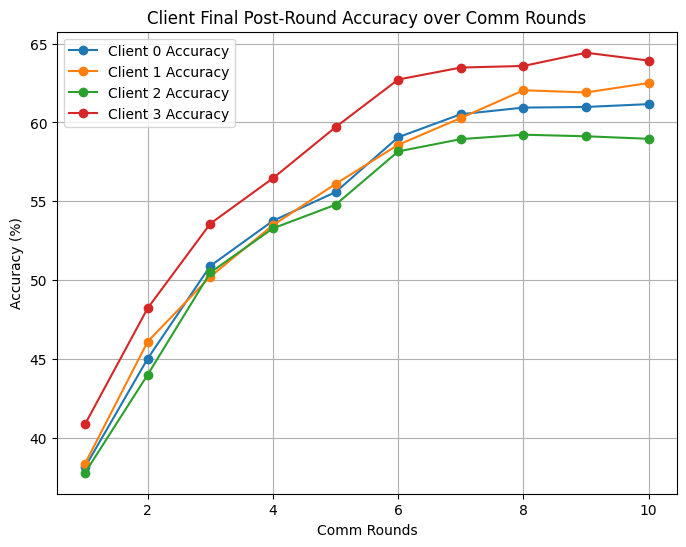


--- Clients Final Evaluation on Private Data sets ---

--- Client 0 Evaluation ---
Client 0 Final Private Data Validation Accuracy: 59.11%

--- Client 1 Evaluation ---
Client 1 Final Private Data Validation Accuracy: 67.17%

--- Client 2 Evaluation ---
Client 2 Final Private Data Validation Accuracy: 68.75%

--- Client 3 Evaluation ---
Client 3 Final Private Data Validation Accuracy: 65.67%

Final Server Test Accuracy (on Public test_set): 56.99%


In [14]:
# Hyperparameters
BATCH_SIZE = 64
LEARNING_RATE = 0.01
DISTILLATION_CLIENT_EPOCHS = 5
NUM_EPOCHS = 5
SERVER_EPOCHS = 10
ALPHA = 1  # Dirichlet distribution concentration parameter (lower = more skewed)
NUM_OF_CLIENTS = 4
DISTILLATION_TEMPERATURE = 3
COMM_ROUND = 10 #the communication round

run_model_improvement_3()

---

| Metric                                               | Baseline Model         (T_soft = 1)         | Improvement 1 Model             | Improvement 2 Model           | Improvement 2.1 Model               |
|------------------------------------------------------|----------------------------------|--------------------------------|--------------------------------|---------------------------------|
| **Client 0 - Public Validation Accuracy**             | 52.58%                           | 58.96%                         | 57.16%                         | 61.16%                          |
| **Client 1 - Public Validation Accuracy**             | 51.46%                           | 60.68%                         | 57.60%                         | 62.50%                          |
| **Client 2 - Public Validation Accuracy**             | 50.74%                           | 56.74%                         | 56.66%                         | 58.96%                          |
| **Client 3 - Public Validation Accuracy**             | 52.64%                           | 61.08%                         | 61.00%                         | 63.92%                          |
| **Client 0 - Private Data Accuracy**                 | 51.71%                           | 58.11%                         | 58.90%                         | 59.11%                          |
| **Client 1 - Private Data Accuracy**                 | 51.69%                           | 64.41%                         | 64.46%                         | 67.17%                          |
| **Client 2 - Private Data Accuracy**                 | 60.29%                           | 68.51%                         | 66.99%                         | 68.75%                          |
| **Client 3 - Private Data Accuracy**                 | 52.63%                           | 60.38%                         | 62.41%                         | 65.67%                          |
| **Final Server Test Accuracy (on Public Test-Set)**  | 46.75%                           | 43.88%                         | 53.20%                         | 56.99%                          |

---

# A Magniloquent Cartographic Orchestration of the Penultimate Cognitive Synthesis Envisioned by the Sagacious Protegé of the Eminently Perspicacious Murtaza Taj. (Visual Analysis)

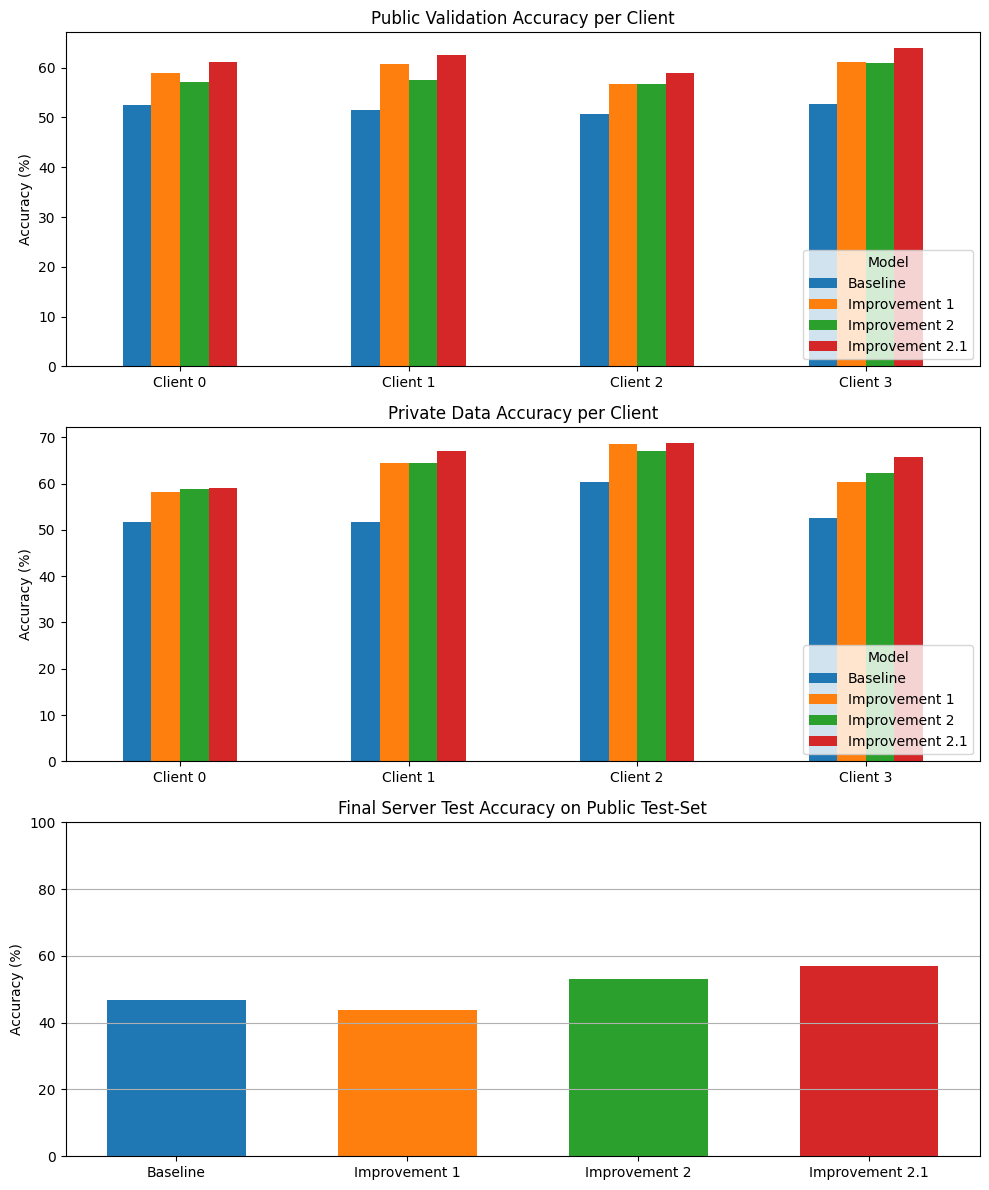

In [ ]:
metrics = ["Client 0", "Client 1", "Client 2", "Client 3"]
public_acc = {
    "Baseline":   [52.58, 51.46, 50.74, 52.64],
    "Improvement 1": [58.96, 60.68, 56.74, 61.08],
    "Improvement 2": [57.16, 57.60, 56.66, 61.00],
    "Improvement 2.1": [61.16, 62.50, 58.96, 63.92]
}
private_acc = {
    "Baseline":   [51.71, 51.69, 60.29, 52.63],
    "Improvement 1": [58.11, 64.41, 68.51, 60.38],
    "Improvement 2": [58.90, 64.46, 66.99, 62.41],
    "Improvement 2.1": [59.11, 67.17, 68.75, 65.67]
}
server_acc = {
    "Baseline": 46.75,
    "Improvement 1": 43.88,
    "Improvement 2": 53.20,
    "Improvement 2.1": 56.99
}

df_pub = pd.DataFrame(public_acc, index=metrics)
df_priv = pd.DataFrame(private_acc, index=metrics)

fig, axes = plt.subplots(3, 1, figsize=(10, 12))

df_pub.plot(kind="bar", ax=axes[0])
axes[0].set_title("Public Validation Accuracy per Client")
axes[0].set_ylabel("Accuracy (%)")
axes[0].legend(title="Model", loc="lower right")
axes[0].set_xticklabels(metrics, rotation=0)

df_priv.plot(kind="bar", ax=axes[1])
axes[1].set_title("Private Data Accuracy per Client")
axes[1].set_ylabel("Accuracy (%)")
axes[1].legend(title="Model", loc="lower right")
axes[1].set_xticklabels(metrics, rotation=0)

axes[2].bar(server_acc.keys(), server_acc.values(), width=0.6, color=['tab:blue', 'tab:orange', 'tab:green', 'tab:red'])
axes[2].set_title("Final Server Test Accuracy on Public Test-Set")
axes[2].set_ylabel("Accuracy (%)")
axes[2].set_ylim(0, 100)
axes[2].grid(axis='y')

plt.tight_layout()
plt.show()


---

## Rationale for Model Improvement 2

In the baseline federated learning pipeline, the introduction of **personalized logit chilling** in Model Improvement 1 significantly enhanced client-side performance by tailoring softmax temperatures to each client's data heterogeneity. However, this improvement came at the cost of a **drop in server model accuracy** on the public dataset. Specifically, the server's final test accuracy decreased by approximately **3%**, highlighting a critical limitation in the global model's ability to effectively learn from the aggregated client logits. This lead us to believe that our aggregation strategy is the culprit since it was probably too simple to cater to the sharp logits incoming from clients due to chilling, and that there could be a potential scale mismatch of logits. Therefore, we dug more into the **scale mismatch problem** during the distillation process and the development of a solution to improve server generalization.

### The Scale Mismatch Problem in Knowledge Distillation
The paper *Logit Standardization in Knowledge Distillation* identifies a key issue in knowledge distillation pipelines: when different temperatures are used for softmax scaling at the client and server levels, the resulting logits can have **inconsistent scales**. This scale mismatch leads to **higher cross-entropy loss** during the distillation process, as the aggregated logits (teacher) and the student logits (primarily server) are not aligned in magnitude. Consequently, the server model struggles to mimic the aggregated logits which have a different magnitude than its own logits.

To address this, the paper proposes **logit standardization** using **Z-score normalization**, which ensures that logits are standardized to have a mean of 0 and a standard deviation of 1. This normalization balances the scale of logits across clients and the server, enabling more effective distillation and reducing the loss caused by scale inconsistencies. Inspired by this approach, we integrated logit standardization into our pipeline to improve the server model's ability to learn from aggregated client logits.


### Benefits of Logit Standardization
By incorporating logit standardization, Model Improvement 2 achieved the following:
1. **Improved Server Generalization:** The server model's final test accuracy on the public dataset increased significantly, from **43.88% in Model Improvement 1** to **53.20% in Model Improvement 2**. This demonstrates the effectiveness of standardization in addressing the scale mismatch problem and enhancing the server's learning process.
2. **Maintained Client Performance:** Despite the focus on improving server accuracy, client models continued to perform well, with only minor variations in their public and private validation accuracies compared to Model Improvement 1.
3. **Balanced Knowledge Distillation:** The use of standardized logits ensured that both the server and clients benefited from a more balanced and effective bidirectional knowledge distillation process.



---

## Additional Exploration: Model Improvement 2.1

Building on the previous insights from the *Flex&Chill* framework, where **logit chilling** with low temperatures sharpened training on local client data, we have further enhanced our approach by embedding an exponentially decreasing temperature (softmax) function into the personalization scheme. This new function is based on the **heterogeneity scores** of each client relative to the global distribution, ensuring that clients whose data diverges more from the global distribution are encouraged to use sharper logits by applying a lower temperature. This adaptive strategy leads to stronger signals during training, thereby improving accuracy.

The temperature function operates exponentially, as described by:

$$
T(softmax) = 0.99 \cdot e^{-3 \cdot \text{score}}
$$


where the *heterogeneity score* reflects the divergence between a client’s class distribution and the global distribution. The function ensures that when a client’s data is highly heterogeneous (i.e., a high score close to 1), the temperature approaches a very low value (0.05). Conversely, when the client's data is more aligned with the global distribution (i.e., a low score close to 0), the temperature is higher, approaching 0.99.

This exponential logit chilling mechanism resulted in the overall model-2.1's accuracy increasing from 53% to 57%, outperforming the previous model-2 by 3%. Additionally, client-specific accuracies also improved, as expected from the sharper logits produced by the low-temperature application. These results confirm that tailoring the temperature based on client heterogeneity enhances model performance and provides a more personalized training experience.